# House Prices Prediction - Advanced Regression Techniques

**This project was performed on GitLab as part of Multivariate Data Analysis course in a team of five. This is the reupload to GitHub.**

## Introduction to the Ames Housing Dataset

The Ames Housing dataset is an extensive collection of residential property data from Ames, Iowa. Compiled by Dean De Cock for educational purposes, this dataset offers a modern and comprehensive alternative to the classic Boston Housing dataset, featuring 79 explanatory variables that capture nearly every aspect of residential homes.

### Dataset Overview

The Ames Housing dataset is designed to enhance predictive modeling skills, providing a rich playground for exploring feature engineering and advanced regression techniques. The goal is to predict the final sale price of homes based on various attributes, including structural features and neighborhood characteristics.

### Features

- **79 Explanatory Variables**: These include details about the properties such as size, type, construction quality, year built, physical features, and neighborhood amenities.
- **Sales Price Prediction**: The target variable is the *SalePrice*, representing the final price of each home. Your task is to predict this value for the homes in the test set.

[Link to the full competition overwiew](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview)

In [8]:
import warnings
from pathlib import Path 
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.model_selection import GridSearchCV, KFold, learning_curve
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from xgboost import XGBRegressor
from src import (
    RemoveOutliers,
    FeatureSelector,
    method1,
    method2,
    method3,
    plot_accuracy_curve
)

warnings.filterwarnings("ignore")

In [9]:
# Load data (train.csv and test.csv)
train_dir = r'data\train.csv'
test_dir = r'data\test.csv'

# For generating final predictions
new_data = pd.read_csv(test_dir, index_col=["Id"])

raw_data = pd.read_csv(train_dir, index_col=["Id"])
raw_data.sample(10)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
1070          45       RL         60.0     9600   Pave   NaN      Reg   
1106          60       RL         98.0    12256   Pave   NaN      IR1   
252          120       RM         44.0     4750   Pave   NaN      IR1   
906           20       RL         80.0     9920   Pave   NaN      Reg   
817           20       RL          NaN    11425   Pave   NaN      IR1   
616           85       RL         80.0     8800   Pave   NaN      Reg   
245           60       RL          NaN     8880   Pave   NaN      IR1   
310           20       RL         90.0    12378   Pave   NaN      IR1   
187           80       RL          NaN     9947   Pave   NaN      IR1   
297           50       RM         75.0    13710   Pave   NaN      Reg   

     LandContour Utilities LotConfig  ... PoolArea PoolQC  Fence MiscFeature  \
Id                                    ...                                      
1070         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
1106         Lvl    AllPub    Corner  ...        0    NaN    NaN         NaN   
252          HLS    AllPub    Inside  ...        0    NaN    NaN         NaN   
906          Lvl    AllPub    Inside  ...        0    NaN  MnPrv         NaN   
817          Lvl    AllPub    Corner  ...        0    NaN    NaN         NaN   
616          Lvl    AllPub    Inside  ...        0    NaN  MnPrv         NaN   
245          Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
310          Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
187          Lvl    AllPub   CulDSac  ...        0    NaN  GdPrv         NaN   
297          Lvl    AllPub    Inside  ...        0    NaN  MnPrv         NaN   

     MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
Id                                                               
1070       0      5    2007        WD         Normal     135000  
1106       0      4    2010        WD         Normal     325000  
252        0     12    2007        WD         Family     235000  
906        0      2    2010        WD         Normal     128000  
817        0      7    2006        WD         Normal     137000  
616        0      5    2010        WD        Abnorml     137500  
245        0      5    2010        WD         Normal     205000  
310        0     11    2006        WD         Normal     360000  
187        0      6    2009        WD         Normal     173000  
297        0      6    2007        WD         Normal     152000  

[10 rows x 80 columns]

In [10]:
# Split columns into lists of numerical and categorical
numerical_cols = list(raw_data.select_dtypes(include=["int64", "float64"]).columns)
categorical_cols = list(raw_data.select_dtypes(exclude=["int64", "float64"]).columns)

In [11]:
# Split dataframe into numerical and categorical features
numerical_data = raw_data.select_dtypes(include=["int64", "float64"])
categorical_data = raw_data.select_dtypes(exclude=["int64", "float64"])

# EDA

In [12]:
print(f"There are {raw_data.shape[0]} observations and {raw_data.shape[1]} columns in the dataset, SalePrice is to be predicted.")

There are 1460 observations and 80 columns in the dataset, SalePrice is to be predicted.


In [13]:
print("Simple statistic of non-numerical columns:")
raw_data.describe(include='object').T

Simple statistic of non-numerical columns:


count unique      top  freq
MSZoning       1460      5       RL  1151
Street         1460      2     Pave  1454
Alley            91      2     Grvl    50
LotShape       1460      4      Reg   925
LandContour    1460      4      Lvl  1311
Utilities      1460      2   AllPub  1459
LotConfig      1460      5   Inside  1052
LandSlope      1460      3      Gtl  1382
Neighborhood   1460     25    NAmes   225
Condition1     1460      9     Norm  1260
Condition2     1460      8     Norm  1445
BldgType       1460      5     1Fam  1220
HouseStyle     1460      8   1Story   726
RoofStyle      1460      6    Gable  1141
RoofMatl       1460      8  CompShg  1434
Exterior1st    1460     15  VinylSd   515
Exterior2nd    1460     16  VinylSd   504
MasVnrType      588      3  BrkFace   445
ExterQual      1460      4       TA   906
ExterCond      1460      5       TA  1282
Foundation     1460      6    PConc   647
BsmtQual       1423      4       TA   649
BsmtCond       1423      4       TA  1311
BsmtExposure   1422      4       No   953
BsmtFinType1   1423      6      Unf   430
BsmtFinType2   1422      6      Unf  1256
Heating        1460      6     GasA  1428
HeatingQC      1460      5       Ex   741
CentralAir     1460      2        Y  1365
Electrical     1459      5    SBrkr  1334
KitchenQual    1460      4       TA   735
Functional     1460      7      Typ  1360
FireplaceQu     770      5       Gd   380
GarageType     1379      6   Attchd   870
GarageFinish   1379      3      Unf   605
GarageQual     1379      5       TA  1311
GarageCond     1379      5       TA  1326
PavedDrive     1460      3        Y  1340
PoolQC            7      3       Gd     3
Fence           281      4    MnPrv   157
MiscFeature      54      4     Shed    49
SaleType       1460      9       WD  1267
SaleCondition  1460      6   Normal  1198

In [14]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuilt    

We could potentially drop the following columns, based on the information above (all of them are object columns):
- *Alley*
- *MasVnrType*
- *FireplaceQu*
- *PoolQC*
- *Fence*
- *MiscFeature*

But firstly we need explore further, to make sure that the empty values are in fact missing values, not the ones that represent 'the lack of some property'. Because in this case, it is valuable information, which can affect the target column.

After checking **data_description.txt** we get to know that NaN in:
- *Alley* means: No alley access
- *MasVnrType* means: None (potentially to drop)
- *FireplaceQu* means: No Fireplace
- *PoolQC* means: No Pool
- *Fence* means: No Fence
- *MiscFeature* means: None (looking at the description file this one may be rather important)

And therefore for most of those columns rather needs renaming NaN with a new category name.

In [15]:
# Checking for NaN values
nan_series = raw_data.isnull().sum()
nan_series[nan_series > 0]

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [16]:
# Checking for duplicates
raw_data.duplicated().any()

False

There are no duplicates in this dataset.

In [17]:
# Displaying potential outliers
z_scores = stats.zscore(raw_data[numerical_cols])
threshold = 3
outliers = (abs(z_scores) > threshold).any(axis=1)
raw_data[outliers]

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
2             20       RL         80.0     9600   Pave   NaN      Reg   
4             70       RL         60.0     9550   Pave   NaN      IR1   
6             50       RL         85.0    14115   Pave   NaN      IR1   
8             60       RL          NaN    10382   Pave   NaN      IR1   
9             50       RM         51.0     6120   Pave   NaN      Reg   
...          ...      ...          ...      ...    ...   ...      ...   
1446          85       RL         70.0     8400   Pave   NaN      Reg   
1451          90       RL         60.0     9000   Pave   NaN      Reg   
1458          70       RL         66.0     9042   Pave   NaN      Reg   
1459          20       RL         68.0     9717   Pave   NaN      Reg   
1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities LotConfig  ... PoolArea PoolQC  Fence MiscFeature  \
Id                                    ...                                      
2            Lvl    AllPub       FR2  ...        0    NaN    NaN         NaN   
4            Lvl    AllPub    Corner  ...        0    NaN    NaN         NaN   
6            Lvl    AllPub    Inside  ...        0    NaN  MnPrv        Shed   
8            Lvl    AllPub    Corner  ...        0    NaN    NaN        Shed   
9            Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
...          ...       ...       ...  ...      ...    ...    ...         ...   
1446         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
1451         Lvl    AllPub       FR2  ...        0    NaN    NaN         NaN   
1458         Lvl    AllPub    Inside  ...        0    NaN  GdPrv        Shed   
1459         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
1460         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   

     MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
Id                                                               
2          0      5    2007        WD         Normal     181500  
4          0      2    2006        WD        Abnorml     140000  
6        700     10    2009        WD         Normal     143000  
8        350     11    2009        WD         Normal     200000  
9          0      4    2008        WD        Abnorml     129900  
...      ...    ...     ...       ...            ...        ...  
1446       0      5    2007        WD         Normal     129000  
1451       0      9    2009        WD         Normal     136000  
1458    2500      5    2010        WD         Normal     266500  
1459       0      4    2010        WD         Normal     142125  
1460       0      6    2008        WD         Normal     147500  

[423 rows x 80 columns]

Setting up the default threshold, there are 423 rows of potential outliers, out of 1460 all rows making it **28.97%** of data available. We need to think what to do about it but first let us take a look at the distributions of numeric columns.

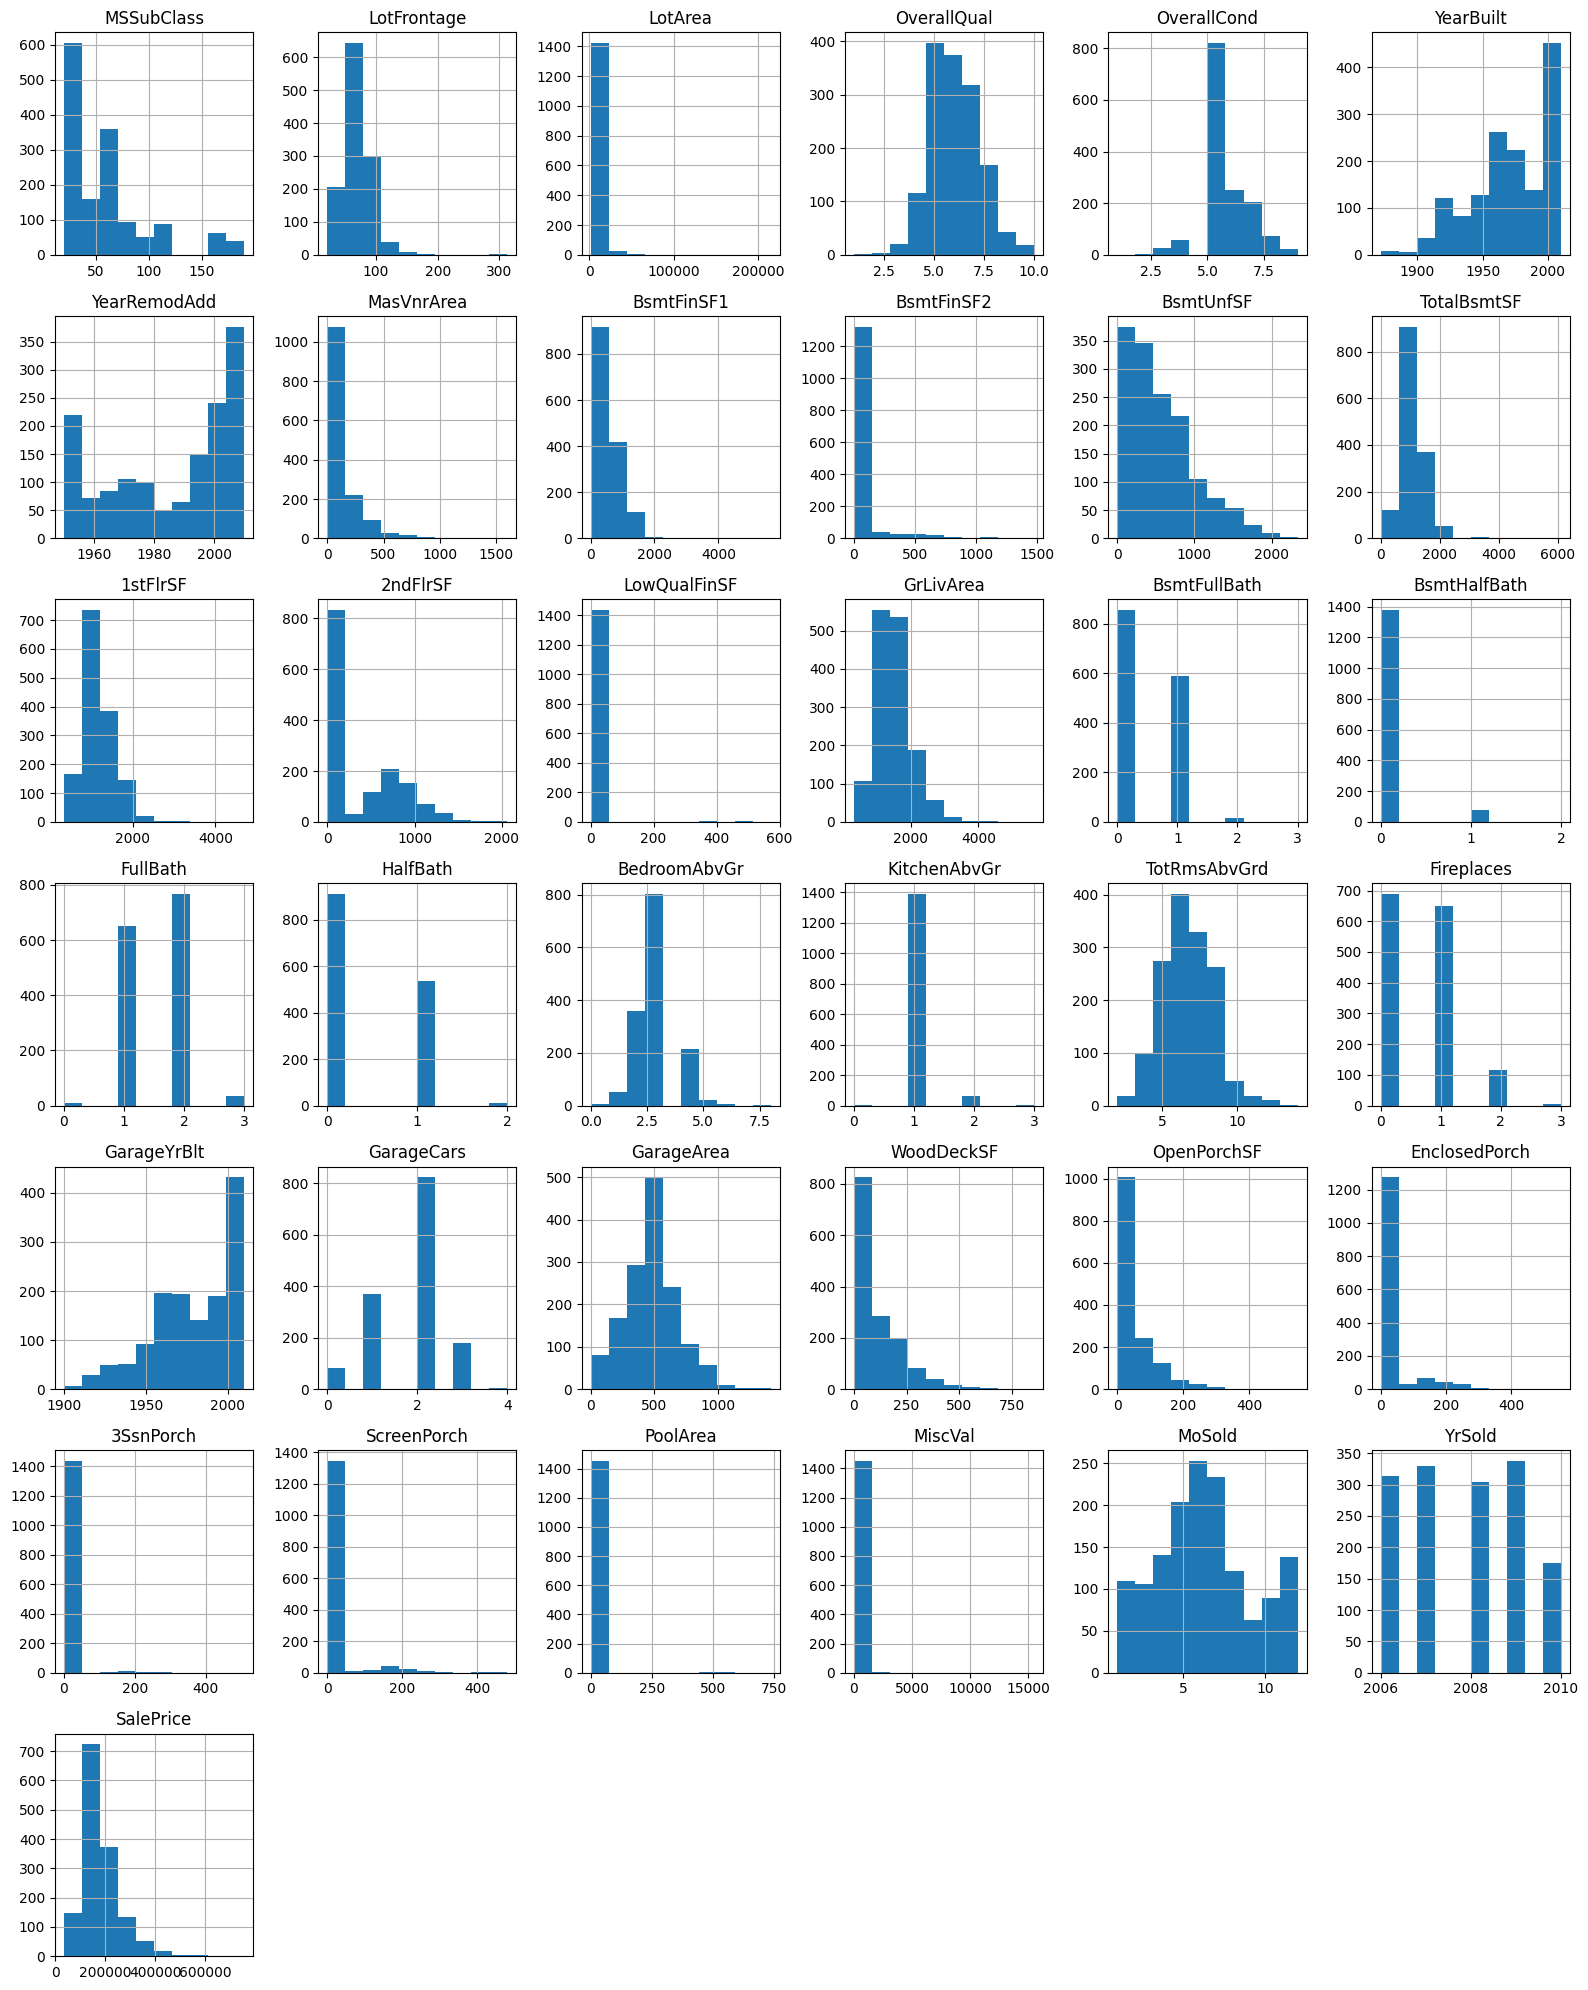

In [18]:
# Distributions of numerical columns
raw_data.hist(figsize=(16, 20))
plt.tight_layout()
plt.show()

From that we may distinguish several skewed distributed data (mostly right-skewed). This shall be addressed during preprocessing.

Next, we can investigate further the distribution of our target variable - _SalePrice_.

In [19]:
# Statistics on SalePrice
raw_data[['SalePrice']].describe()

SalePrice
count    1460.000000
mean   180921.195890
std     79442.502883
min     34900.000000
25%    129975.000000
50%    163000.000000
75%    214000.000000
max    755000.000000

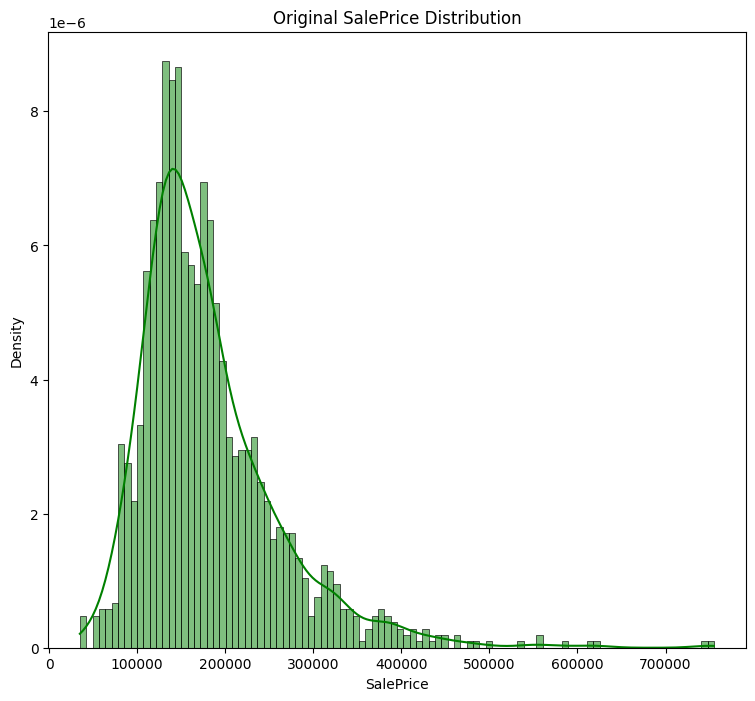

In [20]:
plt.figure(figsize=(9, 8))
sns.histplot(raw_data['SalePrice'], color='g', bins=100, stat = 'density', kde=True)
plt.title('Original SalePrice Distribution')
plt.show()

The prices are skewed right, which can potentially mean occurence of outliers starting from around 500000. One common technique to handle this skewness and reduce the impact of outliers is to apply a logarithmic transformation to the data. This can make the distribution more symmetrical and make the outliers less extreme. This helps the effectivness of performence of linear models.

In [21]:
# Duplicate dataset raw_data
data_log_transformed = raw_data.copy()

# Log transformation
data_log_transformed['SalePrice'] = np.log(data_log_transformed['SalePrice'])

before = raw_data['SalePrice'].describe()
after = data_log_transformed['SalePrice'].describe()

new_column_names = ['Before Log', 'After Log']

combined_df = pd.concat([before, after], axis=1)
combined_df.columns = new_column_names

print("Simple statistics of the target variable before and after logarithmic transformation:")
combined_df

Simple statistics of the target variable before and after logarithmic transformation:


Before Log    After Log
count    1460.000000  1460.000000
mean   180921.195890    12.024051
std     79442.502883     0.399452
min     34900.000000    10.460242
25%    129975.000000    11.775097
50%    163000.000000    12.001505
75%    214000.000000    12.273731
max    755000.000000    13.534473

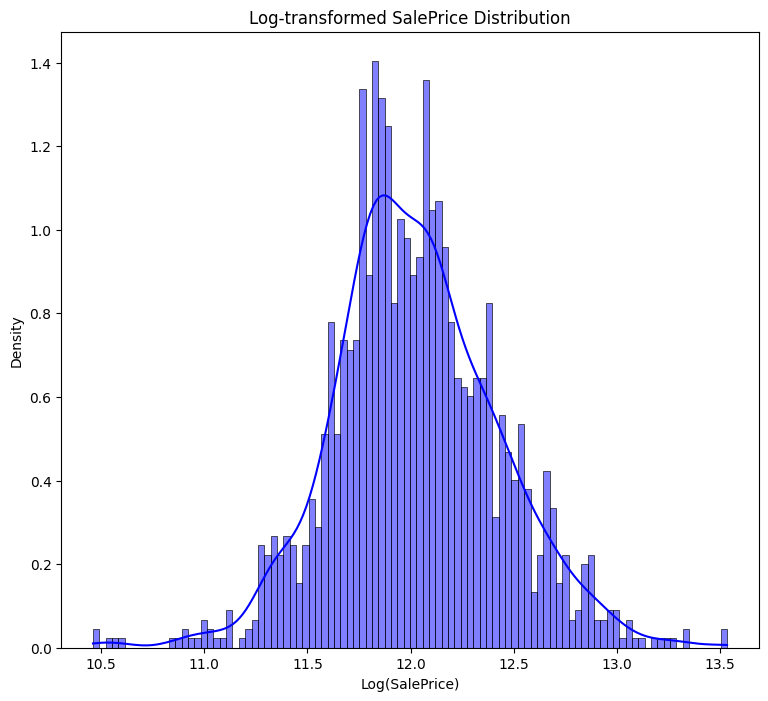

In [22]:
# Transformed histogram
plt.figure(figsize=(9, 8))
sns.histplot(data_log_transformed['SalePrice'], color='b', bins=100, stat='density', kde=True)
plt.title('Log-transformed SalePrice Distribution')
plt.xlabel('Log(SalePrice)')
plt.ylabel('Density')
plt.show()

From the histograms plotted on the raw data, we could clearly see that some features are sharing the similar distribution as *SalePrice*. Thus, it could be valuable to check the correlations now.

## Correlations

### General Correlations Between Features

In [23]:
correlation_matrix = raw_data.corr(numeric_only=True)

# Convert the correlation matrix to a DataFrame
correlation_df = correlation_matrix.unstack().reset_index()
correlation_df.columns = ['Feature1', 'Feature2', 'Correlation']

# Remove self-correlations
correlation_df = correlation_df[correlation_df['Feature1'] != correlation_df['Feature2']]
correlation_df['AbsCorrelation'] = correlation_df['Correlation'].abs()

# Sort the features in each pair and remove duplicates
correlation_df['Pair'] = correlation_df.apply(lambda x: tuple(sorted([x['Feature1'], x['Feature2']])), axis=1)
correlation_df = correlation_df.drop_duplicates(subset=['Pair']).drop(columns=['Pair'])

# Sorting by absolute value of correlations
sorted_correlation_df = correlation_df.sort_values(by='AbsCorrelation', ascending=False)

# Reset the index to start from 1
sorted_correlation_df.reset_index(drop=True, inplace=True)
sorted_correlation_df.index += 1

thr1 = 0.6
top_n = len(sorted_correlation_df[sorted_correlation_df["Correlation"]>thr1])
print(f"Top features with strong correlations (threshold={thr1}):")
sorted_correlation_df.head(top_n)

Top features with strong correlations (threshold=0.6):


Feature1      Feature2  Correlation  AbsCorrelation
1     GarageCars    GarageArea     0.882475        0.882475
2      YearBuilt   GarageYrBlt     0.825667        0.825667
3      GrLivArea  TotRmsAbvGrd     0.825489        0.825489
4    TotalBsmtSF      1stFlrSF     0.819530        0.819530
5    OverallQual     SalePrice     0.790982        0.790982
6      GrLivArea     SalePrice     0.708624        0.708624
7       2ndFlrSF     GrLivArea     0.687501        0.687501
8   BedroomAbvGr  TotRmsAbvGrd     0.676620        0.676620
9     BsmtFinSF1  BsmtFullBath     0.649212        0.649212
10  YearRemodAdd   GarageYrBlt     0.642277        0.642277
11    GarageCars     SalePrice     0.640409        0.640409
12     GrLivArea      FullBath     0.630012        0.630012
13    GarageArea     SalePrice     0.623431        0.623431
14      2ndFlrSF  TotRmsAbvGrd     0.616423        0.616423
15   TotalBsmtSF     SalePrice     0.613581        0.613581
16      2ndFlrSF      HalfBath     0.609707        0.609707
17      1stFlrSF     SalePrice     0.605852        0.605852
18   OverallQual    GarageCars     0.600671        0.600671

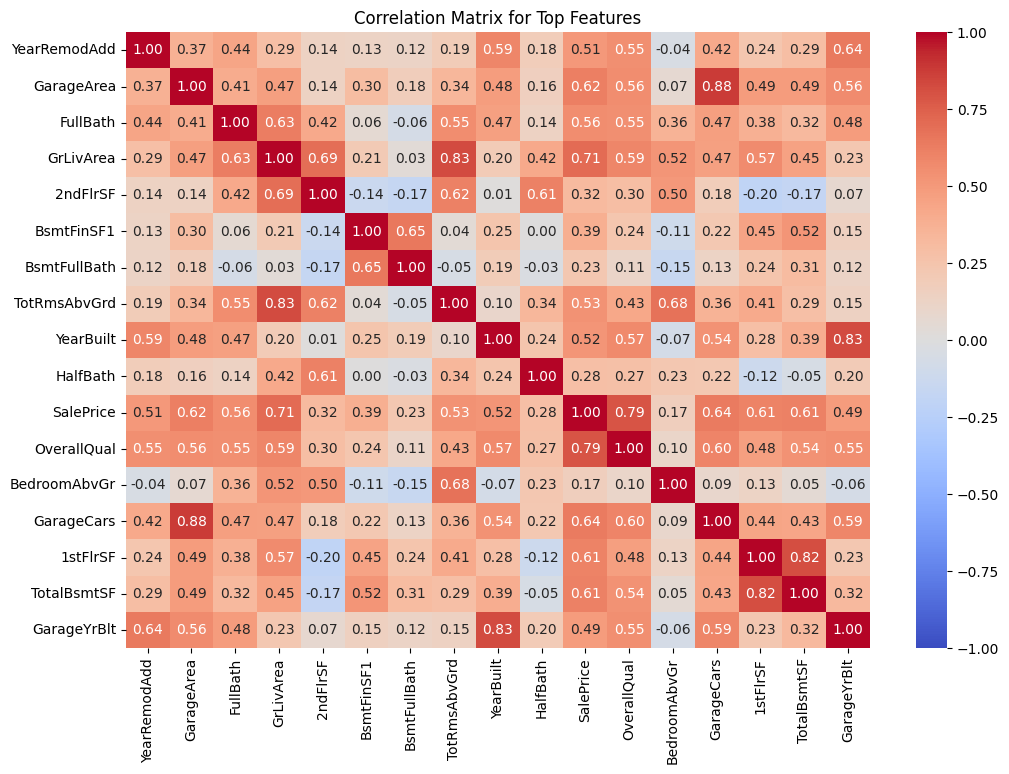

In [24]:
# Get the top correlated features
top_features = list(set(sorted_correlation_df.head(top_n)['Feature1'].tolist() + 
                        sorted_correlation_df.head(top_n)['Feature2'].tolist()))

# Compute the correlation matrix for the top features
top_correlation_matrix = raw_data[top_features].corr()

# Display the correlation matrix for the top features
plt.figure(figsize=(12, 8))
sns.heatmap(top_correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Top Features')
plt.show()

As we can see some of the features with similar distribution to the target variable are indeed correlated with *SalePrice*.

### Correlations with SalePrice

In [25]:
# Dataframe with numeric values only
numeric_data = raw_data.select_dtypes(include=["int64", "float64"])

# Compute the correlation of each feature with SalePrice
saleprice_correlations = numeric_data.corrwith(raw_data['SalePrice']).drop(labels='SalePrice').reset_index()
saleprice_correlations.columns = ['Feature', 'Correlation']

# Add the absolute value of correlations for sorting
saleprice_correlations['AbsCorrelation'] = saleprice_correlations['Correlation'].abs()

# Sort by absolute value of correlations
sorted_saleprice_correlations = saleprice_correlations.sort_values(by='AbsCorrelation', ascending=False)

# Reset the index to start from 1
sorted_saleprice_correlations.reset_index(drop=True, inplace=True)
sorted_saleprice_correlations.index += 1

# display the top correlations
thr2 = 0.6
top_n = len(sorted_saleprice_correlations[sorted_saleprice_correlations["Correlation"] > thr2])
print(f"Top features with strong correlations with SalePrice (threshold={thr2}):")
sorted_saleprice_correlations.head(top_n)

Top features with strong correlations with SalePrice (threshold=0.6):


Feature  Correlation  AbsCorrelation
1  OverallQual     0.790982        0.790982
2    GrLivArea     0.708624        0.708624
3   GarageCars     0.640409        0.640409
4   GarageArea     0.623431        0.623431
5  TotalBsmtSF     0.613581        0.613581
6     1stFlrSF     0.605852        0.605852

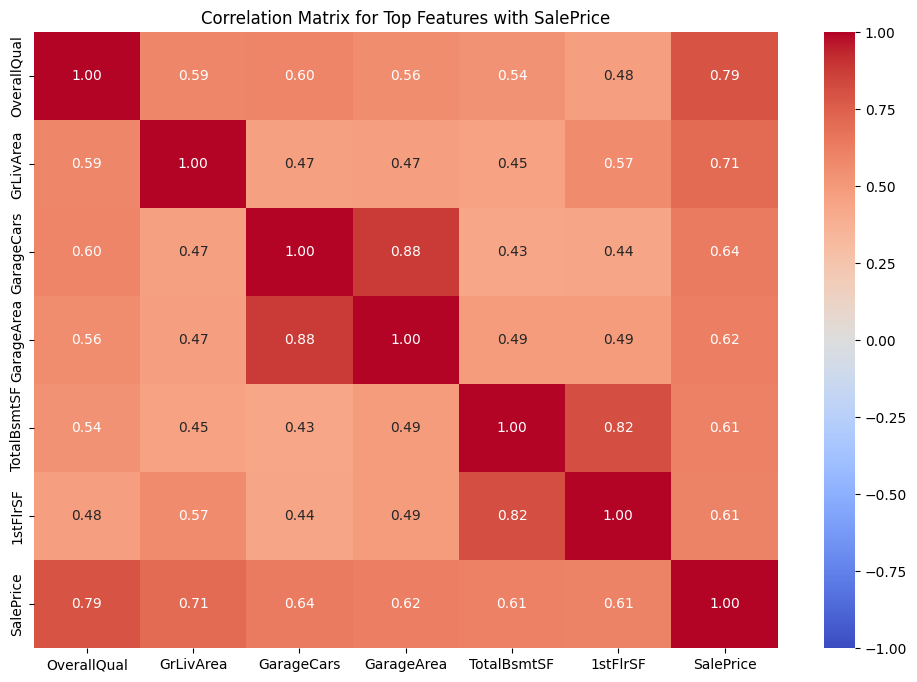

In [26]:
# Get the top correlated features
top_features = sorted_saleprice_correlations.head(top_n)['Feature'].tolist()
top_features.append('SalePrice')  # Add SalePrice to the list of features for correlation matrix

# Compute the correlation matrix for the top features
top_correlation_matrix = raw_data[top_features].corr()

# Display the correlation matrix for the top features as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(top_correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Top Features with SalePrice')
plt.show()

In [27]:
print("top_features:\n")
for i in range(len(top_features)):
    print(top_features[i])

top_features:

OverallQual
GrLivArea
GarageCars
GarageArea
TotalBsmtSF
1stFlrSF
SalePrice


From now on we will be focusing on the features which are correlated (mainly interested in relation to *SalePrice*).

## ANOVA

In [28]:
# Perform ANOVA
anova_results = {}
for feature in categorical_cols:
    groups = raw_data[[feature, 'SalePrice']].dropna().groupby(feature)
    anova_results[feature] = stats.f_oneway(*(group['SalePrice'].values for name, group in groups))

# Convert the results to a DataFrame for better visualization
anova_df = pd.DataFrame({
    'Feature': anova_results.keys(),
    'F-Statistic': [result.statistic for result in anova_results.values()],
    'p-Value': [result.pvalue for result in anova_results.values()]
})

print("Table with ANOVA results:")
anova_df

Table with ANOVA results:


Feature  F-Statistic        p-Value
0        MSZoning    43.840282   8.817634e-35
1          Street     2.459290   1.170486e-01
2           Alley    35.562060   4.899826e-08
3        LotShape    40.132852   6.447524e-25
4     LandContour    12.850188   2.742217e-08
5       Utilities     0.298804   5.847168e-01
6       LotConfig     7.809954   3.163167e-06
7       LandSlope     1.958817   1.413964e-01
8    Neighborhood    71.784865  1.558600e-225
9      Condition1     6.118017   8.904549e-08
10     Condition2     2.073899   4.342566e-02
11       BldgType    13.011077   2.056736e-10
12     HouseStyle    19.595001   3.376777e-25
13      RoofStyle    17.805497   3.653523e-17
14       RoofMatl     6.727305   7.231445e-08
15    Exterior1st    18.611743   2.586089e-43
16    Exterior2nd    17.500840   4.842186e-43
17     MasVnrType    30.746119   2.010580e-13
18      ExterQual   443.334831  1.439551e-204
19      ExterCond     8.798714   5.106681e-07
20     Foundation   100.253851   5.791895e-91
21       BsmtQual   392.913506  9.610615e-186
22       BsmtCond    14.030600   5.136901e-09
23   BsmtExposure    70.887984   1.022671e-42
24   BsmtFinType1    67.602175   1.807731e-63
25   BsmtFinType2     2.702450   1.941009e-02
26        Heating     4.259819   7.534721e-04
27      HeatingQC    88.394462   2.667062e-67
28     CentralAir    98.305344   1.809506e-22
29     Electrical    23.067673   1.663249e-18
30    KitchenQual   407.806352  3.032213e-192
31     Functional     4.057875   4.841697e-04
32    FireplaceQu    24.398929   5.016300e-19
33     GarageType    71.522123   1.247154e-66
34   GarageFinish   250.962467   1.199117e-93
35     GarageQual     9.570389   1.240803e-07
36     GarageCond     9.541161   1.309714e-07
37     PavedDrive    42.024179   1.803569e-18
38         PoolQC     1.627469   3.039853e-01
39          Fence     4.948159   2.312646e-03
40    MiscFeature     2.157324   1.047276e-01
41       SaleType    28.863054   5.039767e-42
42  SaleCondition    45.578428   7.988268e-44

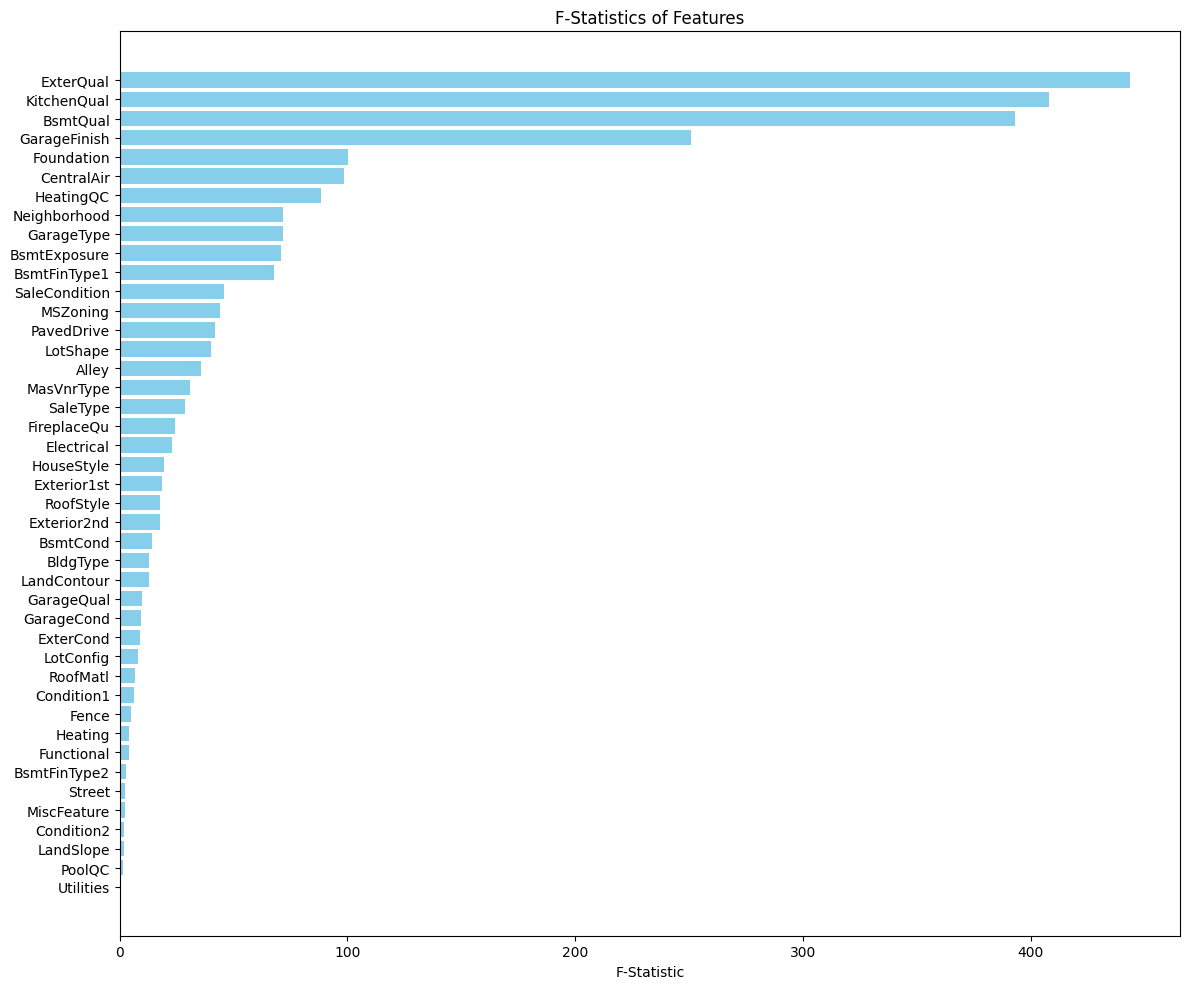

In [29]:
# Sort the results by F-Statistic for better visualization
anova_df_sorted = anova_df.sort_values(by='F-Statistic', ascending=False)

# Plot the F-Statistic
plt.figure(figsize=(12, 10))
plt.barh(anova_df_sorted['Feature'], anova_df_sorted['F-Statistic'], color='skyblue')
plt.xlabel('F-Statistic')
plt.title('F-Statistics of Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

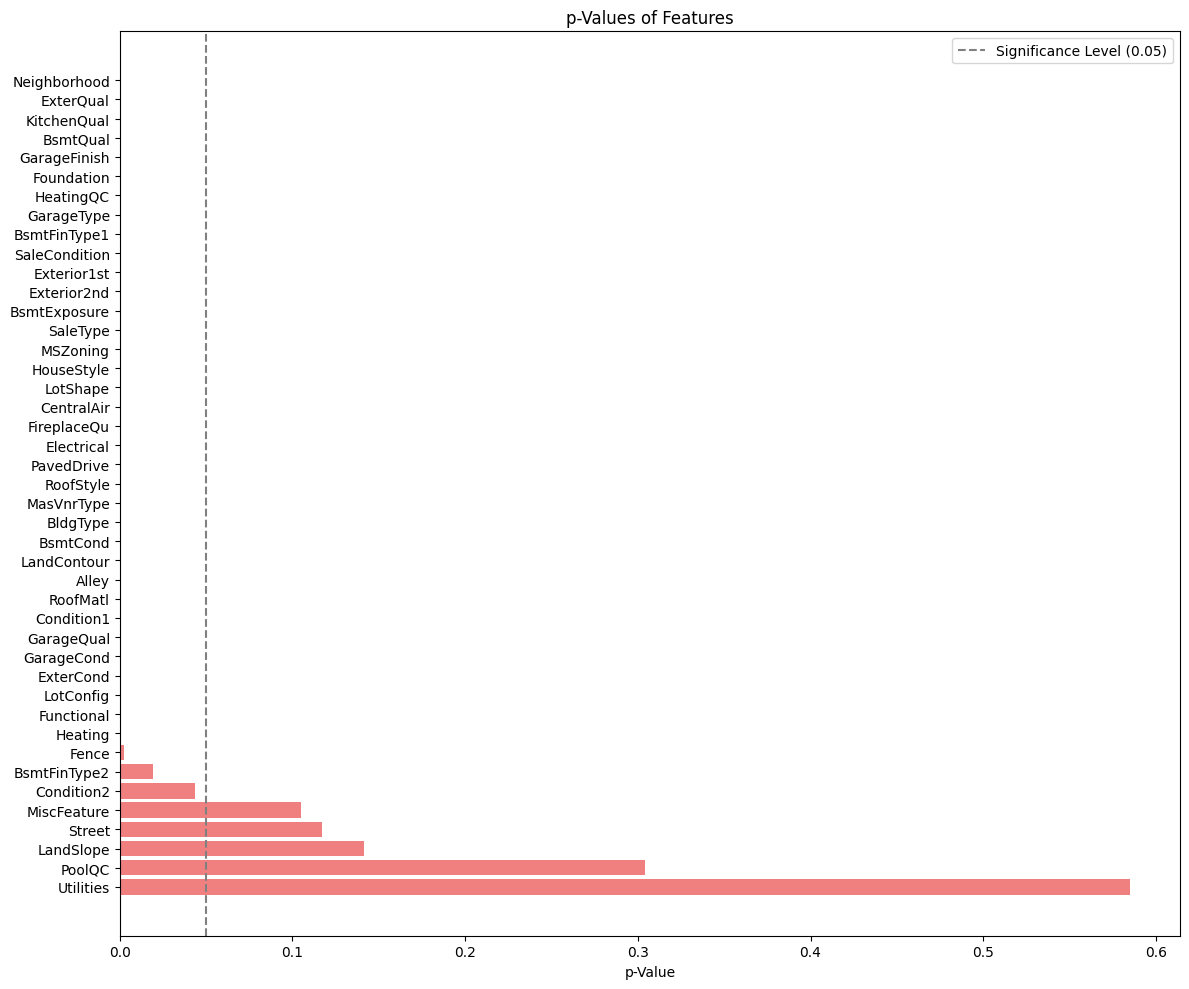

In [30]:
# Sort the results by p-Value for better visualization
anova_df_sorted = anova_df.sort_values(by='p-Value')

# Plot the p-Value
plt.figure(figsize=(12, 10))
plt.barh(anova_df_sorted['Feature'], anova_df_sorted['p-Value'], color='lightcoral')
plt.axvline(0.05, color='gray', linestyle='--', label='Significance Level (0.05)')
plt.xlabel('p-Value')
plt.title('p-Values of Features')
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

1. **F-Statistic Plot**:
- Interpretation: This plot shows the strength of the effect of each feature on *SalePrice*.
- Higher F-statistics indicate a stronger influence.
- Features like: 
    - *ExterQual*,
    - *BsmtQual*, 
    - *KitchenQual*, 
    - *Neighborhood*,
    - *GarageFinish* 
    
    have the highest F-statistics, suggesting they have a strong impact on *SalePrice*.


2. **p-Value Plot:**
- Interpretation: This plot shows the statistical significance of the effect of each feature on *SalePrice*.
- Features with p-values below 0.05 (gray dashed line) are considered statistically significant.
- Most features are below this threshold, indicating their significant influence on *SalePrice*.
- Features like: 
    - *Street*, 
    - *LandSlope*,
    - *PoolQC*,
    - *MiscFeature* 
    
    have higher p-values, indicating they are not statistically significant.

## Pairplots

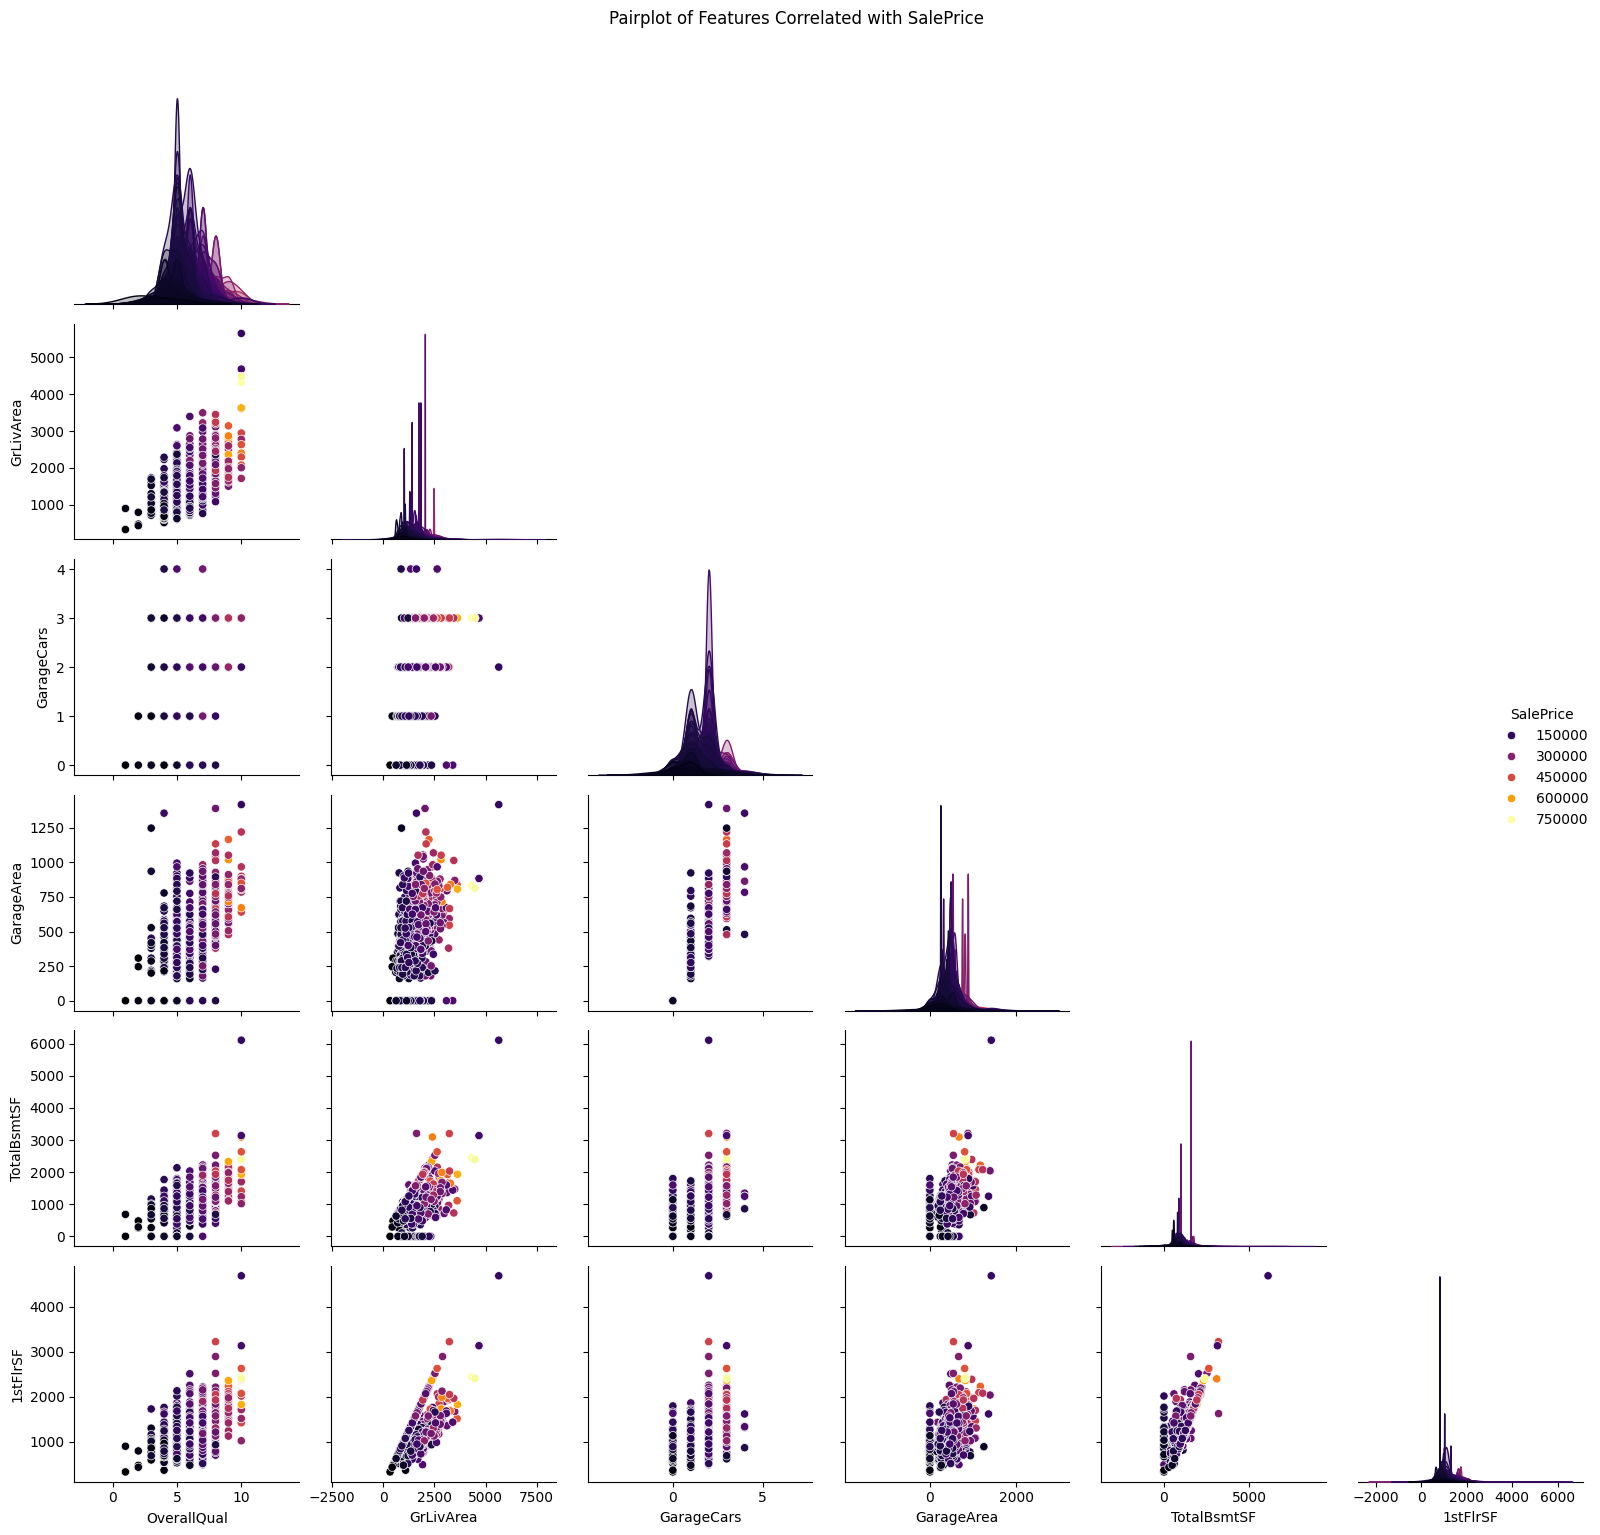

In [31]:
# Create pairplot for features correlated with SalePrice
sns.pairplot(raw_data[top_features], hue ='SalePrice', palette="inferno", corner=True)
plt.suptitle("Pairplot of Features Correlated with SalePrice", y=1.02)
plt.tight_layout()
plt.show()

Here are our observations:

1. **SalePrice Distribution**: As we noticed earlier, the histogram in the diagonal plot for SalePrice shows a right-skewed distribution, indicating that most properties have sale prices below the mean, with fewer high-priced outliers.

2. **Feature Distributions**:
   - *OverallQual*: Shows a near-normal distribution, with a peak around 5-7, indicating most properties have average to above-average quality.
   - *GrLivArea*: Right-skewed distribution, similar to SalePrice, indicating most properties have a moderate living area, with fewer properties having very large living areas.
   - *GarageCars* and *GarageArea*: Both show right-skewed distributions, with most properties having garages that can accommodate 1-2 cars and moderate garage areas.
   - *TotalBsmtSF*: Right-skewed, indicating most basements have moderate square footage.
   - *1stFlrSF* and *FullBath*: Right-skewed, with most properties having moderate first floor areas and 1-2 full bathrooms.
   - *TotRmsAbvGrd*: Shows a near-normal distribution, peaking around 5-7 rooms, indicating most properties have a moderate number of rooms above ground.

3. **Relationships**:
   - *OverallQual vs. SalePrice*: Strong positive correlation, as higher quality ratings correspond to higher sale prices.
   - *GrLivArea vs. SalePrice*: Positive correlation, indicating larger living areas are associated with higher sale prices.
   - *GarageCars/GarageArea vs. SalePrice*: Positive correlation, suggesting more garage capacity and larger garage areas are linked with higher sale prices.
   - *TotalBsmtSF vs. SalePrice*: Positive correlation, indicating larger basement areas correspond to higher sale prices.
   - *1stFlrSF vs. SalePrice*: Positive correlation, with larger first floor areas linked to higher sale prices.
   - *FullBath vs. SalePrice*: Positive correlation, indicating more full bathrooms are associated with higher sale prices.
   - *TotRmsAbvGrd vs. SalePrice*: Positive correlation, with more rooms above ground correlating with higher sale prices.

## Box Plots

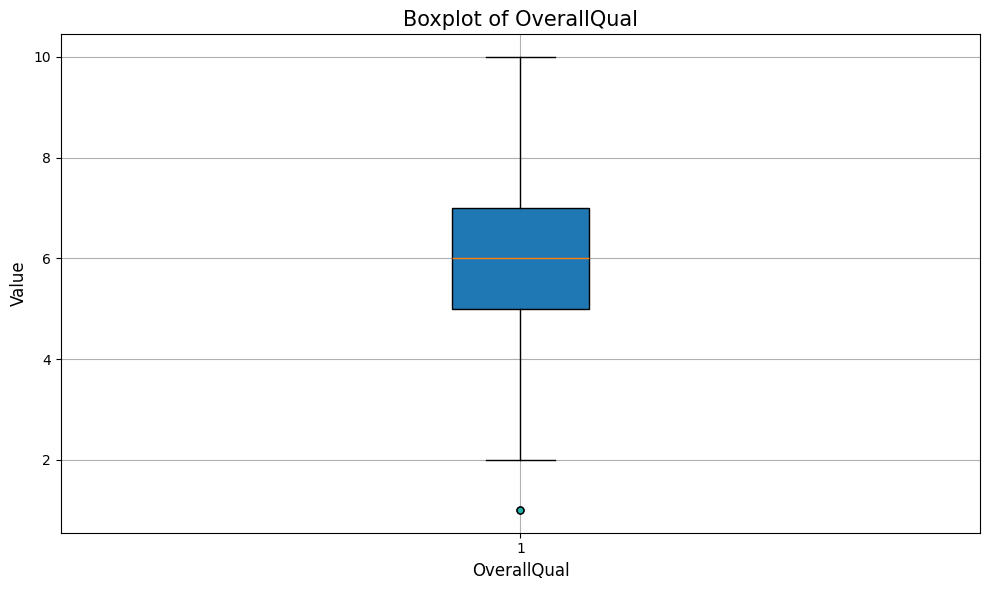

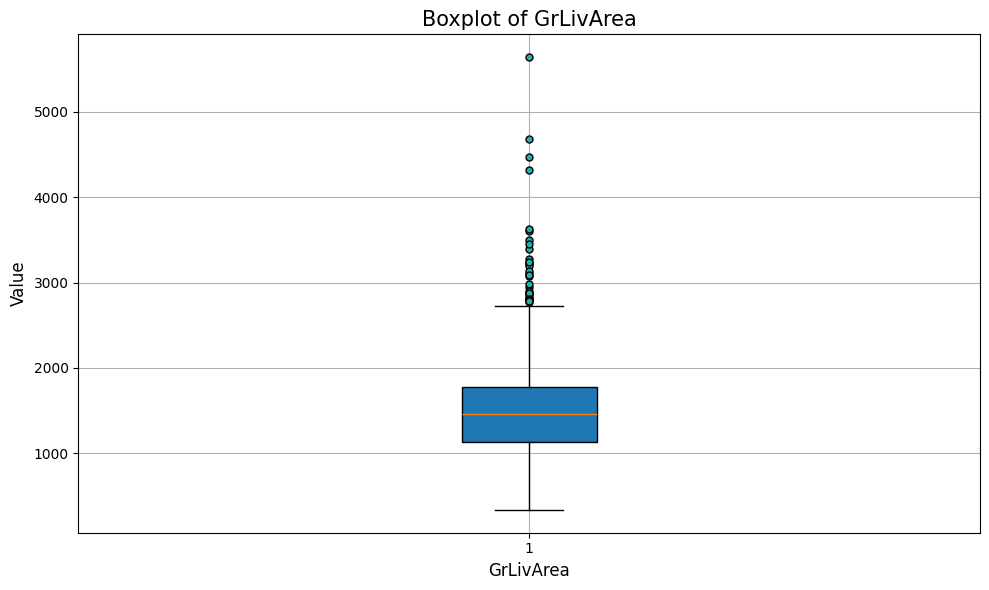

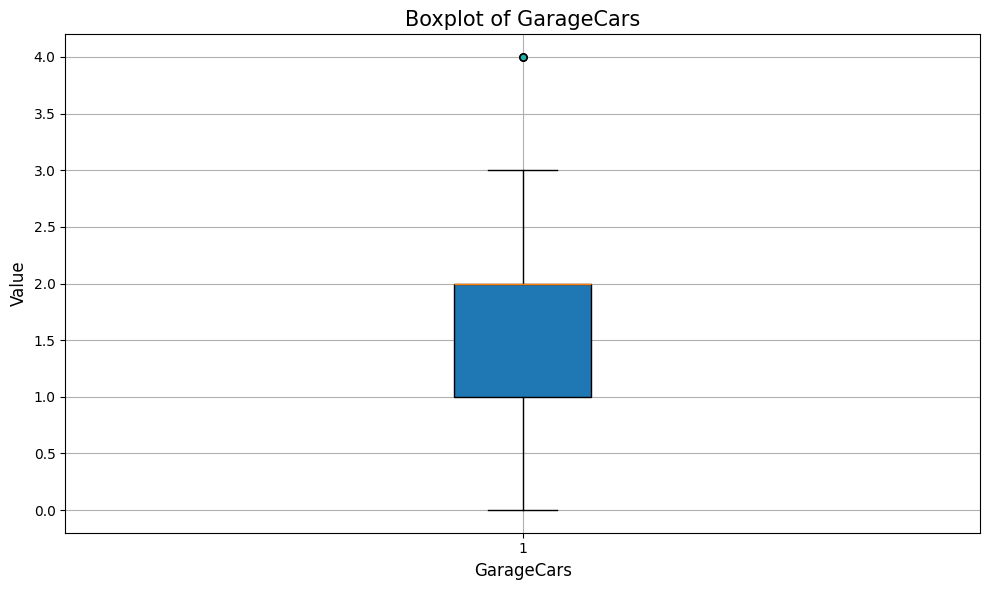

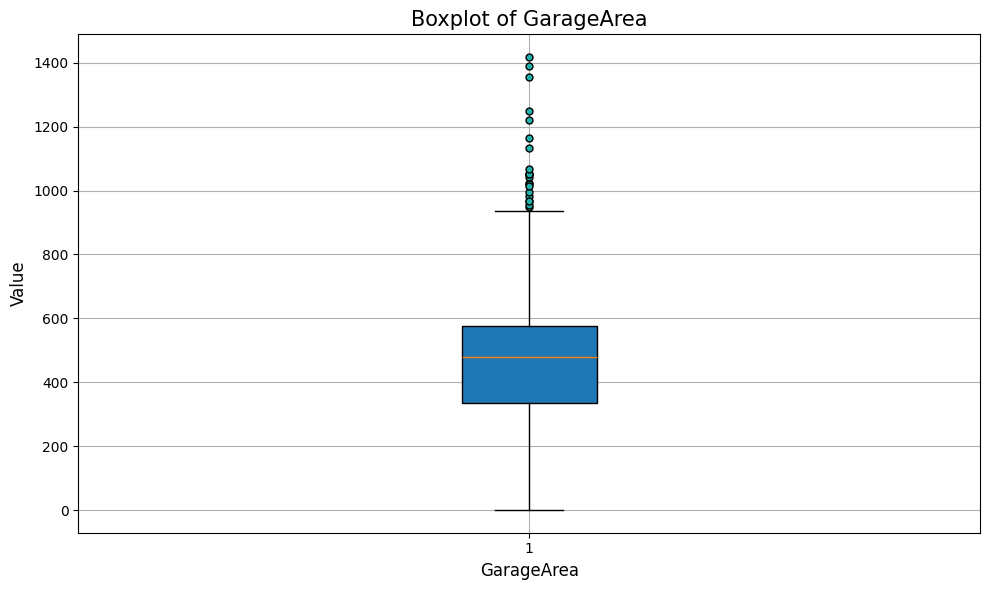

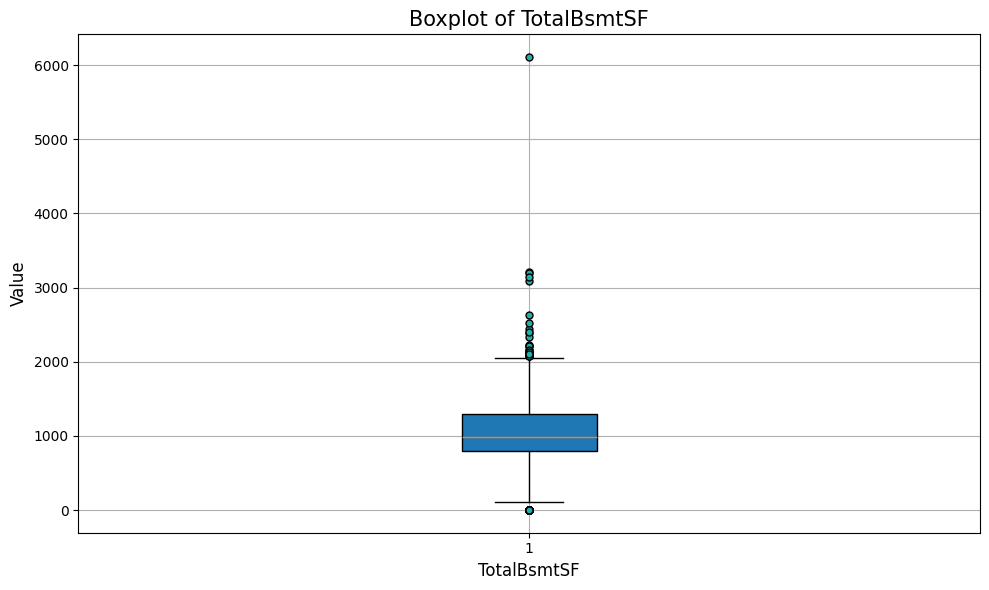

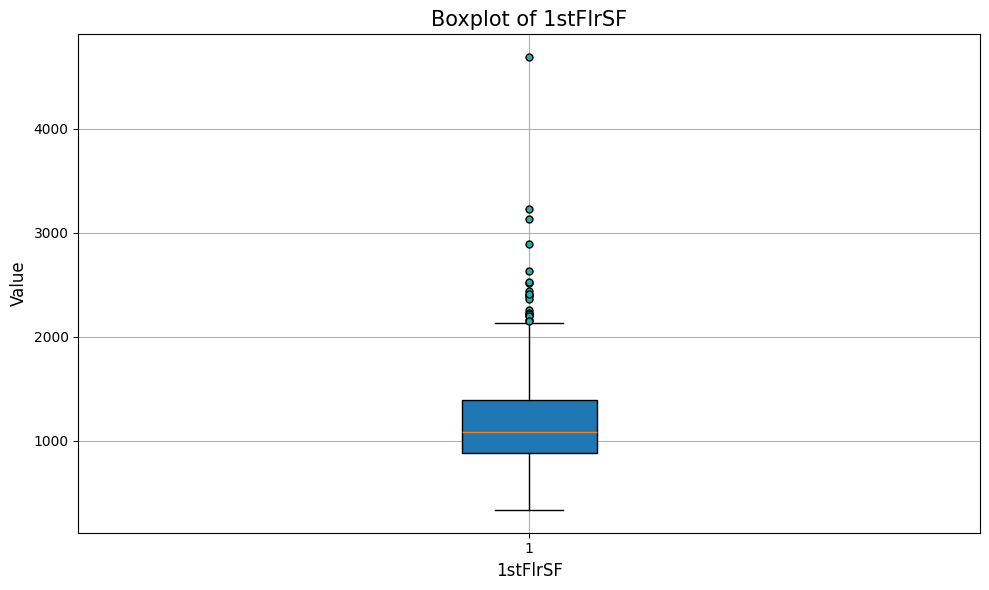

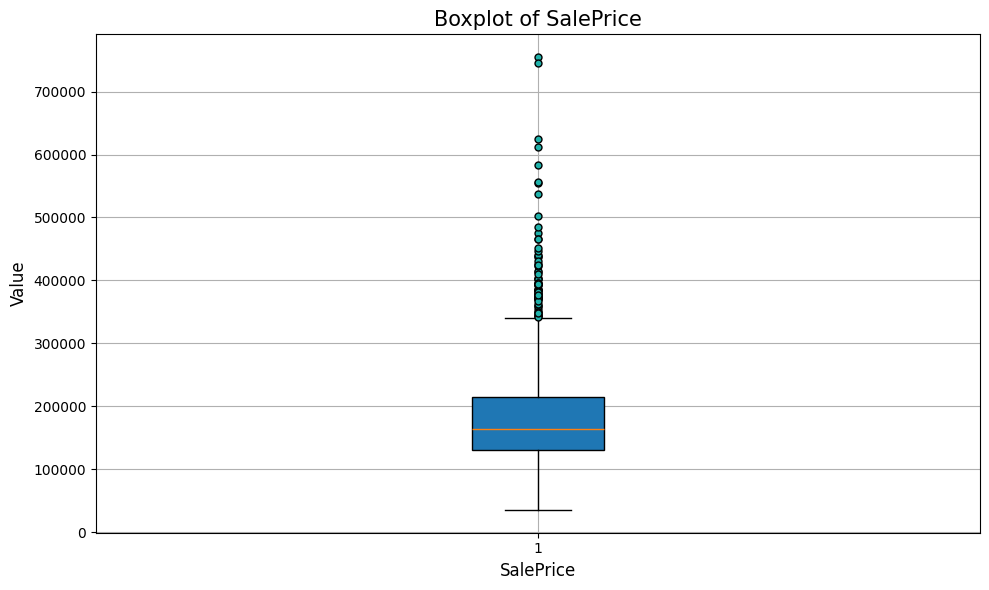

In [32]:
for feature in top_features:
    plt.figure(figsize=(10, 6))
    plt.boxplot(raw_data[feature], 
                flierprops=dict(marker='o', markersize=5, markerfacecolor='lightseagreen'), 
                patch_artist=True)
    plt.title(f'Boxplot of {feature}', fontsize=15)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Brief Visualization of Categorical Variables

In [33]:
print(f'There are {len(categorical_cols)} non-numerical features including:\n')
for i in range(len(categorical_cols)):
    print(categorical_cols[i])

There are 43 non-numerical features including:

MSZoning
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
PoolQC
Fence
MiscFeature
SaleType
SaleCondition


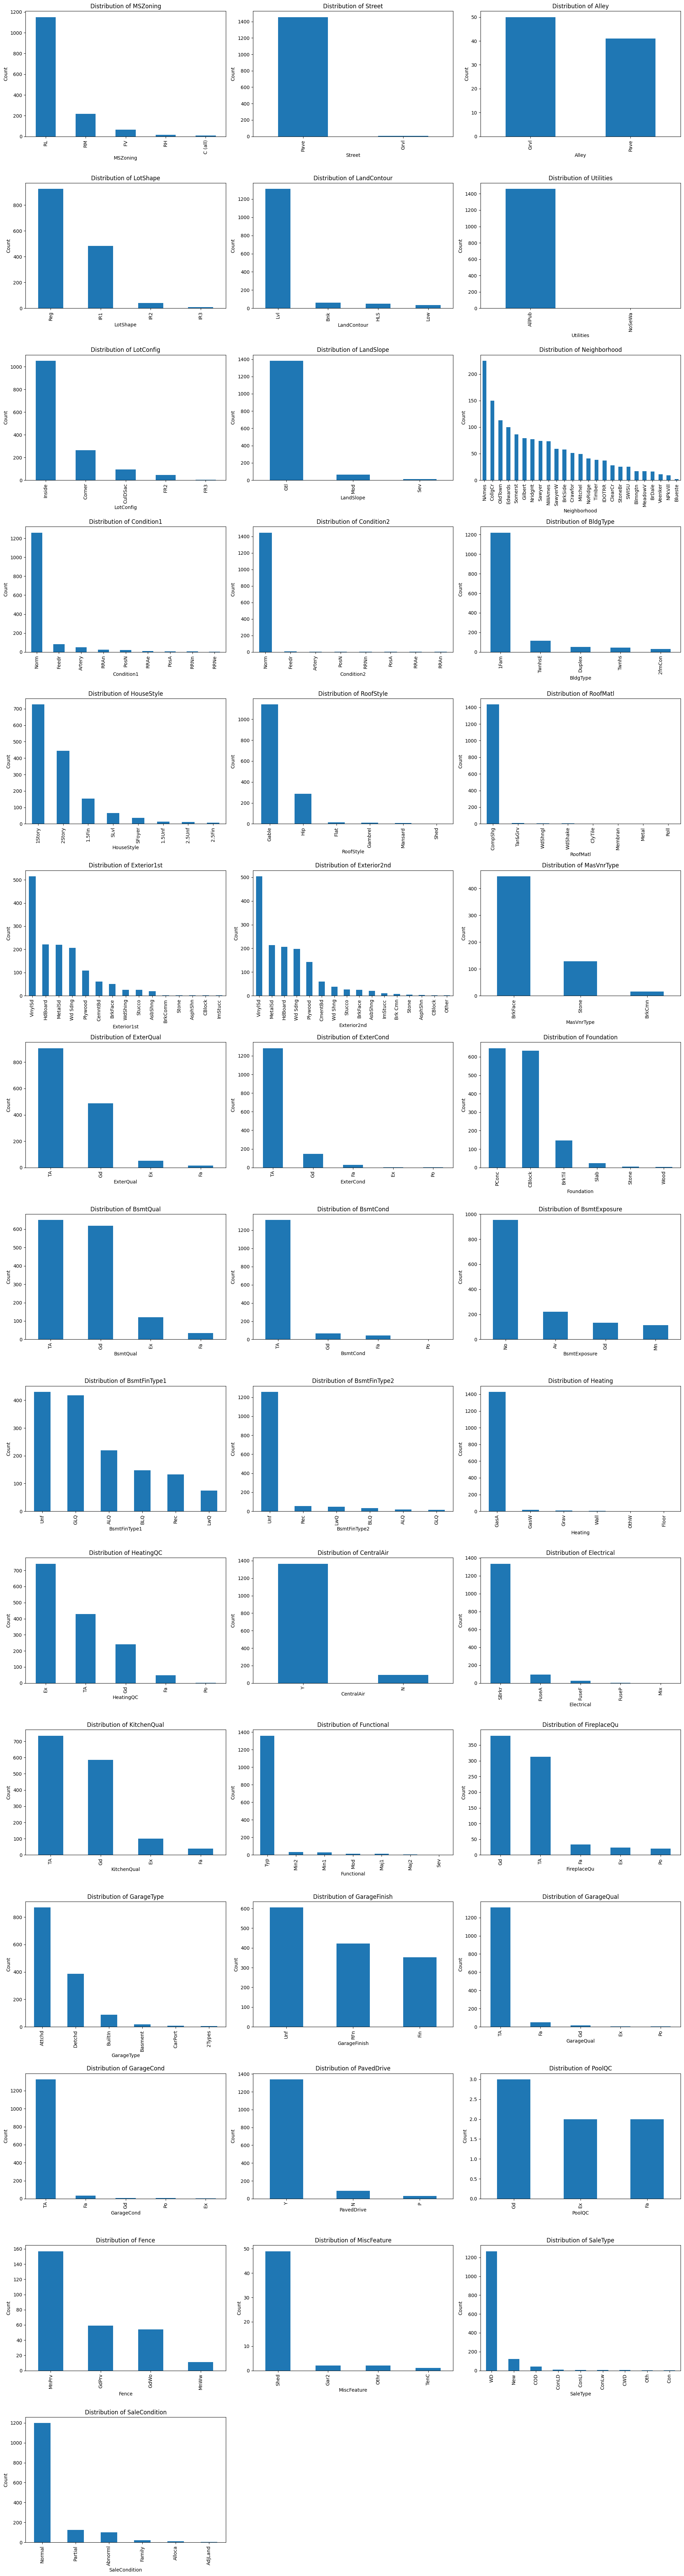

In [34]:
# Ensure non-numerical columns are categorical
for col in categorical_cols:
    raw_data[col] = raw_data[col].astype('category')

num_cols = len(categorical_cols)
num_plots_per_row = 3
num_rows = (num_cols + num_plots_per_row - 1) // num_plots_per_row  # Calculate the required number of rows

fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(20, 5 * num_rows))
axes = axes.flatten()  # makes it work idk why

for i, feature in enumerate(categorical_cols):
    value_counts = raw_data[feature].value_counts()
    ax = axes[i]
    value_counts.plot(kind='bar', ax=ax)
    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Some categories dominate certain features like:
- *Utilities*, 
- *Heating*, 
- *GarageCond*, 
- *Functional*. 

Because of this dominance, these features might not be significant for our predictive model.

# Data Cleaning & Preprocessing

## Different Preprocessing Methods

In [35]:
# raw_data copied
raw_data_copy = raw_data.copy()

We decided to experiment a bit with preprocessing to observe how much it may actually affect the accuracy of predictions. For this reason, three preprocessing methods were invented and applied to each of the models. Then, the cross-validation score (mainly its mean and standard deviation) present how well a particular model fits data using a specific preprocessing method. This experiment aims to measure how data volume and usage of specific data transformations affects final predictions. This is not a full experiment, as there would be need to consider every case, every combination (e.g. using all columns excluding those marked as insignificant which is not there), but just an overview of some kind.

Additionally, this preprocessing distinguishes data between categorical, numerical skewed and numerical non-skewed:
- ```skewed_pipeline``` is comprised of ```SimpleImputer``` with the median strategy and ```PowerTransformer```, which not only resolves the problem of skewed data distribution in a particular column, but also standardize this data,
- ```num_pipeline``` varies from the previous pipeline only by replacing ```PowerTransformer``` with ```StandardScaler```, which is presumably not necessary for normally-looking distributed data to be preprocessed further in that aspect,
- ```cat_pipeline``` for categorical data utilizes ```SimpleImputer``` as well, but this time it creates new categories in place of NaN. We concluded that all of the NaN in features actually stand as separate categories of something (e.g., for a column *Fence* NaN is: No Fence, which means that we know that we have no fence there - this is not an unknown value). Then these columns are transformed into multiple corersponding columns with 0 and 1 with `OneHotEncoder`.

Considering multiple options on how to prepare an efficient preprocessing, three variants were selected:
- **Method 1:**
  - This one uses **all columns** from the dataset, adjusting the pipelines in accordance with their data type. It additionally uses ```TransformedTargetRegressor``` (inside `method1` from **src.py**) to transform *SalePrice* and make it more Gaussian-like (because it is a skewed data column as proved above)
- **Method 2:**
  - It uses **only** ```top_features``` from the dataset and then proceeds in the same way as in the previous point (so in fact it only varies by the data volume from the method 1)
- **Method 3:**
  - Again uses all columns from the dataset and proceeds with the same transformations but this time **without** ```TransformedTargetRegressor``` for the dependent variable and **without** ```PowerTransform``` for all independent variables

  At the end, every method returns DataFrame with cross-validation scores based on R2 and RMSE metrics. Moreover, for every model, each function generates two more dataframes with statistics based on RMSE and R2, respectively. They are crucial for the summary.

**Different issue**

We encountered a problem with including ```RemoveOutliers``` inside preprocessing pipelines which are down below and there is why, it is applied here as the primary one and outside of any pipeline. In fact, it is impossible to use an instance of this class inside any preprocessing pipeline created, due to the mismatch between the number of rows in the feature columns and the target variable. It is a consequence of using preprocessing pipelines only for independent variables (causing the mismatch because some rows were deleted from features but the same rows remain intact in the target variable). We had many attempts to overcome this issue in any way, but as they all failed, we are left with this, rather messy implementation.

In [36]:
remove_outliers = RemoveOutliers(threshold=5)
df = remove_outliers.fit_transform(raw_data_copy)
df

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
1             60       RL         65.0     8450   Pave   NaN      Reg   
2             20       RL         80.0     9600   Pave   NaN      Reg   
3             60       RL         68.0    11250   Pave   NaN      IR1   
4             70       RL         60.0     9550   Pave   NaN      IR1   
5             60       RL         84.0    14260   Pave   NaN      IR1   
...          ...      ...          ...      ...    ...   ...      ...   
1454          20       RL         90.0    17217   Pave   NaN      Reg   
1455          20       FV         62.0     7500   Pave  Pave      Reg   
1456          60       RL         62.0     7917   Pave   NaN      Reg   
1457          20       RL         85.0    13175   Pave   NaN      Reg   
1458          70       RL         66.0     9042   Pave   NaN      Reg   

     LandContour Utilities LotConfig  ... PoolArea PoolQC  Fence MiscFeature  \
Id                                    ...                                      
1            Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
2            Lvl    AllPub       FR2  ...        0    NaN    NaN         NaN   
3            Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
4            Lvl    AllPub    Corner  ...        0    NaN    NaN         NaN   
5            Lvl    AllPub       FR2  ...        0    NaN    NaN         NaN   
...          ...       ...       ...  ...      ...    ...    ...         ...   
1454         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
1455         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
1456         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
1457         Lvl    AllPub    Inside  ...        0    NaN  MnPrv         NaN   
1458         Lvl    AllPub    Inside  ...        0    NaN  GdPrv        Shed   

     MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
Id                                                               
1          0      2    2008        WD         Normal     208500  
2          0      5    2007        WD         Normal     181500  
3          0      9    2008        WD         Normal     223500  
4          0      2    2006        WD        Abnorml     140000  
5          0     12    2008        WD         Normal     250000  
...      ...    ...     ...       ...            ...        ...  
1454       0      7    2006        WD        Abnorml      84500  
1455       0     10    2009        WD         Normal     185000  
1456       0      8    2007        WD         Normal     175000  
1457       0      2    2010        WD         Normal     210000  
1458    2500      5    2010        WD         Normal     266500  

[1376 rows x 80 columns]

The decision is not to use the default (and most intuitive) 3 std from the mean, as it would remove almost one third of the data. After considering that:
- threshold = 3std -> 28.98% of data removed
- threshold = 4std -> 14.18% of data removed
- threshold = 5std -> 5.75% of data removed

the conclusion is that we leave 5 as the parameter for ```RemoveOutliers```.

Additionaly, ```train_test_split``` is not applied here. The reason is that we claimed that since there are only 1376 columns, maybe it would be better to use it all as training data (knowing that are purpose is to predict *SalePrice* values from 1460 long **test.csv** file). As a consequence the following code determines the most efficient model based solely on ```cross_val_score``` applied to each model. Subsequently, the plan is to fit training data using the model selected (the best one) to predict the results on data from **test.csv** and see how well we did (well, we actually will not be able to see how well we did).

In [37]:
# Separate features and target
X = df.drop(columns=["SalePrice"]).copy()
y = df["SalePrice"].copy()

In [38]:
# Features split into numerical and categorical (without target variable)
num_cols = list(X.select_dtypes(include=[int, float]).columns)
cat_cols = list(X.select_dtypes(exclude=[int, float]).columns)

After seeing data distributions of attributes, we select those that are skewed (left or right) to use enhanced preprocessing procedure compared to features which distribution imitates normal distribution.

In [39]:
skewed_columns = ['GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 
                  'FullBath', 'MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea',
                  'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '2ndFlrSF', 'GarageYrBlt', 
                  'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 
                  'ScreenPorch', 'PoolArea', 'MiscVal']

## General Preprocessing Pipelines

In [40]:
# Preprocessing pipeline for skewed numeric data
skewed_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    PowerTransformer(method='yeo-johnson', standardize=True)
)

# Preprocessing pipeline for non-skewed numeric data
num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

# Preprocessing pipeline for categorical data
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="new_cat"),
    OneHotEncoder(handle_unknown="ignore")
)

## Method 1

In [41]:
# Full preprocessing transformer using all columns
preprocessing1 = make_pipeline(
    ColumnTransformer(
    transformers=[
        ('num', num_pipeline, list(filter(lambda col: col not in skewed_columns, num_cols))),
        ('skewed', skewed_pipeline, skewed_columns),
        ('cat', cat_pipeline, cat_cols)
    ]
))

It is worth mentioning that functions: ```method1```, ```method2``` and ```method3``` fit preprocessed data with models inside the functions and hopefully it is not a bad thing to do. They are available in **src.py**.

## Method 2

In [42]:
# top_features without target variable
top_features = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF']

# For this method it is necessary to create new 'X'
X_top = X[top_features]

# Filtering columns to keep only those in top_features
filtered_num_cols = list(set(num_cols) & set(top_features))
filtered_skewed_columns = list(set(skewed_columns) & set(top_features))
filtered_cat_cols = list(set(cat_cols) & set(top_features))

# Full preprocessing pipeline with top_features only
preprocessing2 = make_pipeline(
    FeatureSelector(top_features=top_features),
    ColumnTransformer(
        transformers=[
            ('num', num_pipeline, filtered_num_cols),
            ('skewed', skewed_pipeline, filtered_skewed_columns),
            ('cat', cat_pipeline, filtered_cat_cols)
        ]
    )
)

## Method 3

In [43]:
# The only pipeline changed
skewed_pipeline3 = make_pipeline(
    SimpleImputer(strategy="median"),
    # PowerTransformer(method='yeo-johnson', standardize=True)   # getting rid of that
    StandardScaler()   # instead of PowerTransformer() 
)

# Full preprocessing for all columns without PowerTransformer
preprocessing3 = make_pipeline(
    ColumnTransformer(
    transformers=[
        ('num', num_pipeline, list(filter(lambda col: col not in skewed_columns, num_cols))),
        ('skewed', skewed_pipeline3, skewed_columns),
        ('cat', cat_pipeline, cat_cols)
    ]
))

# Models

Within the cross-validation score we are looking for possibly the lowest mean and standard deviation to determine the best model in the most efficient preprocessing method.

For now, we do not use any hyperparameters. The plan is to perform hyperparameters tuning after declaring 'the best' model.

## Linear Regression

At first we consider linear regression as the most straightforward to implement and interpret. On the other hand, it assumes linear relationships, which might not capture complex interactions between features and is sensitive to outliers (our dataset is full of them!! ).

### Method 1

In [44]:
lin_reg_cross_val1, lin_reg_rmse_describe1, lin_reg_r2_describe1 = method1(LinearRegression(), X, y, preprocessing1)
lin_reg_cross_val1

LinearRegression -> RMSE  LinearRegression -> R2
1               20816.897540                0.907999
2               18755.222328                0.954848
3               17231.602796                0.933576
4               17127.786531                0.945275
5               18991.192756                0.946287
6               18670.956849                0.905211
7               20221.894571                0.933644
8               19672.872836                0.925529
9               23724.131173                0.896241
10              14255.443380                0.940550

### Method 2

In [45]:
# Here instead of entire matrix of features X, only X_top - matrix of top_features
lin_reg_cross_val2, lin_reg_rmse_describe2, lin_reg_r2_describe2 = method2(LinearRegression(), X_top, y, preprocessing2)
lin_reg_cross_val2

LinearRegression -> RMSE  LinearRegression -> R2
1               22502.904228                0.892493
2               31002.776183                0.876624
3               23210.662853                0.879483
4               27657.419821                0.857305
5               30535.466525                0.861137
6               24814.458206                0.832569
7               29527.376771                0.858524
8               27661.812907                0.852765
9               34801.829948                0.776721
10              22439.647094                0.852692

### Method 3

In [46]:
lin_reg_cross_val3, lin_reg_rmse_describe3, lin_reg_r2_describe3 = method3(LinearRegression(), X, y, preprocessing3)
lin_reg_cross_val3

LinearRegression -> RMSE  LinearRegression -> R2
1               22551.111692                0.892032
2               23830.929322                0.927103
3               19519.983678                0.914762
4               21101.430555                0.916937
5               20642.469680                0.936540
6               20974.095614                0.880383
7               24008.459598                0.906467
8               19809.641851                0.924490
9               25733.488098                0.877921
10              16606.188427                0.919326

Surprisingly, the simplest ```LinearRegression``` already proves to be a great choice. Especially, the first preprocessing method i.e., we use all columns and transform the skewed columns to more normally-distributed, presents explanatory power oscillating about 92% and low RMSE error. This is an encouragement to try more linear models.

## Ridge

Adds penalty terms to control for overfitting, making the model more robust. 

### Method 1

In [47]:
ridge_cross_val1, ridge_rmse_describe1, ridge_r2_describe1 = method1(Ridge(alpha=0.5), X, y, preprocessing1)
ridge_cross_val1

Ridge -> RMSE  Ridge -> R2
1    19860.606821     0.916258
2    18575.222894     0.955711
3    16568.935799     0.938587
4    16834.199978     0.947135
5    18814.051963     0.947284
6    18229.175126     0.909643
7    19948.437079     0.935427
8    19414.599741     0.927472
9    23205.063871     0.900732
10   14196.857815     0.941037

### Method 2

In [48]:
ridge_cross_val2, ridge_rmse_describe2, ridge_r2_describe2 = method2(Ridge(alpha=0.5), X_top, y, preprocessing2)
ridge_cross_val2

Ridge -> RMSE  Ridge -> R2
1    22533.203916     0.892204
2    31066.974687     0.876113
3    23149.656591     0.880115
4    27659.028287     0.857288
5    30060.037497     0.865427
6    24771.805735     0.833144
7    29644.605952     0.857398
8    27644.210053     0.852952
9    34722.710305     0.777735
10   22432.078400     0.852792

### Method 3

In [49]:
ridge_cross_val3, ridge_rmse_describe3, ridge_r2_describe3 = method3(Ridge(alpha=0.5), X, y, preprocessing3)
ridge_cross_val3

Ridge -> RMSE  Ridge -> R2
1    21606.649749     0.900886
2    23448.955919     0.929421
3    18121.853753     0.926535
4    20375.897937     0.922550
5    20261.015726     0.938864
6    19945.728964     0.891825
7    23995.943746     0.906565
8    19668.794332     0.925560
9    25712.679706     0.878118
10   16390.687753     0.921406

```Ridge``` is actually a lot better. Every R2 score above 0.9, with the mean probably exceeding 0.93. Since this is a linear model, the number of columns (data) does not really make a difference in terms of computational complexity. It took less than two seconds to run every method function.

## Lasso

Lasso can perform feature selection by shrinking some coefficients to zero.

### Method 1

In [50]:
lasso_cross_val1, lasso_rmse_describe1, lasso_r2_describe1 = method1(Lasso(alpha=0.01), X, y, preprocessing1) # alpha=0.5, max_iter=5000
lasso_cross_val1

Lasso -> RMSE  Lasso -> R2
1    18691.437807     0.925827
2    27087.167113     0.905821
3    19311.543040     0.916573
4    21799.564110     0.911350
5    24297.769942     0.912075
6    20289.725953     0.888062
7    28755.672976     0.865822
8    22898.346673     0.899108
9    28098.214812     0.854453
10   18138.220214     0.903754

### Method 2

In [51]:
lasso_cross_val2, lasso_rmse_describe2, lasso_r2_describe2 = method2(Lasso(alpha=0.01), X_top, y, preprocessing2)
lasso_cross_val2

Lasso -> RMSE  Lasso -> R2
1    23338.507204     0.884361
2    32612.388493     0.863481
3    23523.289396     0.876214
4    28079.034688     0.852921
5    29617.433153     0.869361
6    24771.149721     0.833153
7    30931.673820     0.844747
8    27556.039016     0.853889
9    34884.263141     0.775662
10   22655.149053     0.849850

### Method 3

In [52]:
lasso_cross_val3, lasso_rmse_describe3, lasso_r2_describe3 = method3(Lasso(alpha=0.01), X, y, preprocessing3)
lasso_cross_val3

Lasso -> RMSE  Lasso -> R2
1    22630.108619     0.891274
2    23918.109042     0.926569
3    19497.529410     0.914958
4    21386.850777     0.914674
5    20625.539708     0.936644
6    20672.802592     0.883795
7    24006.606232     0.906482
8    19810.153238     0.924486
9    25684.830362     0.878382
10   16606.159250     0.919326

For ```Lasso```, we had to declare `alpha=0.01`. Without that, the scores would be something like -bilion on R2. Although, still ```Ridge``` takes the lead.

## Elastic Net

### Method 1

In [53]:
elnet_cross_val1, elnet_rmse_describe1, elnet_r2_describe1 = method1(ElasticNet(alpha=0.01), X, y, preprocessing1)
elnet_cross_val1

ElasticNet -> RMSE  ElasticNet -> R2
1         18692.443018          0.925819
2         25889.745083          0.913963
3         18989.566595          0.919331
4         20608.836687          0.920770
5         23185.357399          0.919942
6         20021.779441          0.890999
7         27561.464166          0.876735
8         21888.551972          0.907810
9         26748.105995          0.868104
10        17668.779650          0.908672

### Method 2

In [54]:
elnet_cross_val2, elnet_rmse_describe2, elnet_r2_describe2 = method2(ElasticNet(alpha=0.01), X_top, y, preprocessing2) 
elnet_cross_val2

ElasticNet -> RMSE  ElasticNet -> R2
1         23611.609812          0.881639
2         31808.498691          0.870128
3         23216.414908          0.879423
4         27858.648643          0.855221
5         29776.101973          0.867958
6         24892.191323          0.831518
7         30313.370302          0.850891
8         27389.166636          0.855653
9         34706.351940          0.777944
10        22540.217106          0.851369

### Method 3

In [55]:
elnet_cross_val3, elnet_rmse_describe3, elnet_r2_describe3 = method3(ElasticNet(alpha=0.01), X, y, preprocessing3)
elnet_cross_val3

ElasticNet -> RMSE  ElasticNet -> R2
1         20600.582783          0.909901
2         22606.562509          0.934401
3         17074.401771          0.934782
4         18974.029781          0.932841
5         19956.381938          0.940688
6         18861.077813          0.903270
7         23884.261722          0.907433
8         19157.763118          0.929378
9         25466.633739          0.880439
10        15911.819338          0.925932

There, the same alpha as before had to be implemented and for the same reason as before, yielding very similar results.

## SVR (linear & polynomial)

### Method 1

#### ```kernel = "linear"```

In [56]:
svr_cross_val1_lin, svr_rmse_describe1_lin, svr_r2_describe1_lin = method1(SVR(kernel="linear"), X, y, preprocessing1)
svr_cross_val1_lin

SVR -> RMSE  SVR -> R2
1   20088.620644   0.914324
2   19401.371887   0.951684
3   17648.227200   0.930325
4   17437.206824   0.943280
5   20599.277827   0.936805
6   20321.725595   0.887708
7   21268.858500   0.926595
8   20647.697248   0.917966
9   24550.760144   0.888885
10  15253.985005   0.931929

#### ```kernel = "poly"```

In [57]:
svr_cross_val1_poly, svr_rmse_describe1_poly, svr_r2_describe1_poly = method1(SVR(kernel="poly"), X, y, preprocessing1)
svr_cross_val1_poly

SVR -> RMSE  SVR -> R2
1   19757.766840   0.917123
2   23292.571098   0.930359
3   17857.987277   0.928659
4   19568.054322   0.928570
5   22496.275729   0.924630
6   19519.660096   0.896397
7   19116.637815   0.940700
8   20617.448042   0.918206
9   27712.552783   0.858421
10  17061.453638   0.914842

### Method 2

#### ```kernel = "linear"```

In [58]:
svr_cross_val2_lin, svr_rmse_describe2_lin, svr_r2_describe2_lin = method2(SVR(kernel="linear"), X_top, y, preprocessing2)
svr_cross_val2_lin

SVR -> RMSE  SVR -> R2
1   22372.967353   0.893731
2   30744.931408   0.878668
3   23036.718484   0.881282
4   27839.165723   0.855424
5   30849.413432   0.858267
6   25013.159835   0.829877
7   28955.529564   0.863950
8   27613.340289   0.853281
9   34863.453045   0.775929
10  22316.799984   0.854301

#### ```kernel = "poly"```

In [59]:
svr_cross_val2_poly, svr_rmse_describe2_poly, svr_r2_describe2_poly = method2(SVR(kernel="poly"), X_top, y, preprocessing2)
svr_cross_val2_poly

SVR -> RMSE  SVR -> R2
1    61127.996367   0.206697
2    33311.858051   0.857562
3    56587.193041   0.283674
4    56892.938137   0.396188
5   136834.451900  -1.788486
6    36511.376853   0.637521
7    35185.594823   0.799107
8    36209.838209   0.747708
9    55677.365656   0.428519
10   43358.602405   0.450024

### Method 3

#### ```kernel = "linear"```

In [60]:
svr_cross_val3_lin, svr_rmse_describe3_lin, svr_r2_describe3_lin = method3(SVR(kernel="linear"), X, y, preprocessing3)
svr_cross_val3_lin

SVR -> RMSE  SVR -> R2
1   62892.803485   0.160230
2   84914.271888   0.074471
3   60289.690366   0.186869
4   67540.142875   0.149040
5   79222.975125   0.065284
6   54349.259735   0.196819
7   73492.439747   0.123565
8   65593.225153   0.172120
9   69384.188497   0.112505
10  52822.247056   0.183744

#### ```kernel = "poly"```

In [61]:
svr_cross_val3_poly, svr_rmse_describe3_poly, svr_r2_describe3_poly = method3(SVR(kernel="poly"), X, y, preprocessing3)
svr_cross_val3_poly

SVR -> RMSE  SVR -> R2
1   70415.053124  -0.052664
2   92723.076350  -0.103581
3   67036.245152  -0.005296
4   74881.198099  -0.045998
5   88296.278467  -0.161081
6   60718.490894  -0.002463
7   80926.821223  -0.062721
8   72866.272762  -0.021651
9   76442.353527  -0.077241
10  59656.868423  -0.041151

There is much happening here. The first preprocessing method works well, both kernels applied have similar, high efficiency. The second method is acceptable for linear kernel but the polynomial one is definitely less efficient. The third method is a complete disaster - the R2 score of linear kernel ```SVR``` does not exceed 0.2, while for polynomial the values are even negative, suggesting that it is worse than a horizontal line (the mean of the target variable). It presumably signifies how preprocessing method affected the accuracy of predictions. It looks like in the method 2, the model is a bit underfitted and in the third method the issue could be those skewed columns.

## Random Forest

We know that it combines multiple trees to improve predictive performance and reduce overfitting. However, it is more complex and less interpretable compared to a single decision tree and can be computationally expensive, considering the number of columns we provide.

### Method 1

In [62]:
randfor_cross_val1, randfor_rmse_describe1, randfor_r2_describe1 = method1(RandomForestRegressor(), X, y, preprocessing1)
randfor_cross_val1

RandomForestRegressor -> RMSE  RandomForestRegressor -> R2
1                    19780.670427                     0.916931
2                    30204.413295                     0.882897
3                    20384.711108                     0.907043
4                    22135.946822                     0.908593
5                    26640.774683                     0.894301
6                    20586.666349                     0.884761
7                    29254.264348                     0.861129
8                    23117.336474                     0.897169
9                    32140.508815                     0.809564
10                   18068.668332                     0.904491

### Method 2

In [63]:
randfor_cross_val2, randfor_rmse_describe2, randfor_r2_describe2 = method2(RandomForestRegressor(), X_top, y, preprocessing2)
randfor_cross_val2

RandomForestRegressor -> RMSE  RandomForestRegressor -> R2
1                    24984.952731                     0.867470
2                    33929.612847                     0.852230
3                    25046.438859                     0.859665
4                    28933.330497                     0.843836
5                    30437.996698                     0.862022
6                    23582.380015                     0.848783
7                    29895.587034                     0.854973
8                    25515.382836                     0.874728
9                    35782.925750                     0.763954
10                   22683.350052                     0.849475

### Method 3

In [64]:
randfor_cross_val3, randfor_rmse_describe3, randfor_r2_describe3 = method3(RandomForestRegressor(), X, y, preprocessing3)
randfor_cross_val3

RandomForestRegressor -> RMSE  RandomForestRegressor -> R2
1                    18625.260047                     0.926352
2                    28679.146406                     0.894425
3                    21287.696553                     0.898625
4                    22365.028815                     0.906691
5                    27799.772320                     0.884904
6                    20125.232703                     0.889869
7                    29532.603796                     0.858473
8                    22340.477048                     0.903964
9                    30208.327834                     0.831772
10                   19047.547156                     0.893862

Even though the results seem solid for all methods, given the time it takes for ```RandomForest``` to process this data. We definitely would not like to tune hyperparameters for this one. This is probably the one that did the best job using only `top_features`.

## Gradient Boosting Regressor

Often achieves high predictive accuracy by building trees sequentially and correcting errors of previous trees. It can handle various types of data and distributions. On the other hand, typically requires tedious hyperparameters tuning.

### Method 1

In [65]:
gradboost_cross_val1, gradboost_rmse_describe1, gradboost_r2_describe1 = method1(GradientBoostingRegressor(), X, y, preprocessing1)
gradboost_cross_val1

GradientBoostingRegressor -> RMSE  GradientBoostingRegressor -> R2
1                        18013.095484                         0.931113
2                        23462.759479                         0.929338
3                        17373.691178                         0.932476
4                        20314.287639                         0.923018
5                        22277.368142                         0.926090
6                        17450.645979                         0.917196
7                        24811.762925                         0.900104
8                        22902.398050                         0.899072
9                        28170.221541                         0.853706
10                       17267.374984                         0.912774

### Method 2

In [66]:
gradboost_cross_val2, gradboost_rmse_describe2, gradboost_r2_describe2 = method2(GradientBoostingRegressor(), X_top, y, preprocessing2)
gradboost_cross_val2

GradientBoostingRegressor -> RMSE  GradientBoostingRegressor -> R2
1                        26382.293419                         0.852231
2                        35475.174087                         0.838461
3                        23385.827740                         0.877657
4                        27875.241467                         0.855049
5                        30844.327808                         0.858314
6                        24399.537694                         0.838121
7                        29734.876138                         0.856528
8                        27561.028195                         0.853836
9                        34527.822565                         0.780223
10                       21930.404962                         0.859303

### Method 3

In [67]:
gradboost_cross_val3, gradboost_rmse_describe3, gradboost_r2_describe3 = method3(GradientBoostingRegressor(), X, y, preprocessing3)
gradboost_cross_val3

GradientBoostingRegressor -> RMSE  GradientBoostingRegressor -> R2
1                        18328.454207                         0.928680
2                        24242.301595                         0.924564
3                        17478.288794                         0.931660
4                        20513.428277                         0.921501
5                        24986.377453                         0.907021
6                        17974.362713                         0.912152
7                        25287.633115                         0.896235
8                        21121.693205                         0.914157
9                        26760.191508                         0.867985
10                       17182.268862                         0.913632

```GradientBoostingRegressor``` has the similar results as ```RandomForestRegressor```. At least, the computation time is way shorter but still all linear models are a better choice.

## XGBRegressor

### Method 1

In [68]:
xgb_cross_val1, xgb_rmse_describe1, xgb_r2_describe1 = method1(XGBRegressor(), X, y, preprocessing1)
xgb_cross_val1

XGBRegressor -> RMSE  XGBRegressor -> R2
1           22344.350220            0.894003
2           26685.742624            0.908591
3           20303.560692            0.907781
4           23830.620443            0.894061
5           29504.126082            0.870359
6           20289.202644            0.888067
7           25624.318255            0.893454
8           22839.559409            0.899625
9           29820.983101            0.836059
10          18116.974912            0.903979

### Method 2

In [69]:
xgb_cross_val2, xgb_rmse_describe2, xgb_r2_describe2 = method2(XGBRegressor(), X_top, y, preprocessing2)
xgb_cross_val2

XGBRegressor -> RMSE  XGBRegressor -> R2
1           30305.036693            0.805021
2           35554.119308            0.837741
3           27152.329379            0.835074
4           33185.690708            0.794559
5           32569.149631            0.842024
6           24165.454080            0.841213
7           30918.716997            0.844877
8           30109.838731            0.825552
9           37025.041352            0.747282
10          25378.358458            0.811583

### Method 3

In [70]:
xgb_cross_val3, xgb_rmse_describe3, xgb_r2_describe3 = method3(XGBRegressor(), X, y, preprocessing3)
xgb_cross_val3

XGBRegressor -> RMSE  XGBRegressor -> R2
1           21081.431972            0.905646
2           27185.719008            0.905134
3           18385.360757            0.924383
4           22341.021162            0.906891
5           26084.370827            0.898670
6           19943.966825            0.891844
7           27318.040703            0.878903
8           20906.483343            0.915897
9           29173.799416            0.843097
10          19097.361524            0.893306

```XGBRegressor``` is stable across all preprocessing methods, however linear models still remain invincible.

We omitted to check neural network (e.g. MLP), observing that linear models yield very accurate predictions and there is no necessity to overcomplicate.

# Models Comparison & Summary

In [71]:
# List of cross-validation results (by RMSE) joined altogether
cross_val_rmse = [
    ridge_rmse_describe1, ridge_rmse_describe2, ridge_rmse_describe3,
    lasso_rmse_describe1, lasso_rmse_describe2, lasso_rmse_describe3,
    elnet_rmse_describe1, elnet_rmse_describe2, elnet_rmse_describe3,
    svr_rmse_describe1_lin.rename(columns=lambda x: x + '_linear'), 
    svr_rmse_describe2_lin.rename(columns=lambda x: x + '_linear'), 
    svr_rmse_describe3_lin.rename(columns=lambda x: x + '_linear'),
    svr_rmse_describe1_poly.rename(columns=lambda x: x + '_poly'), 
    svr_rmse_describe2_poly.rename(columns=lambda x: x + '_poly'), 
    svr_rmse_describe3_poly.rename(columns=lambda x: x + '_poly'),
    randfor_rmse_describe1, randfor_rmse_describe2, randfor_rmse_describe3,
    gradboost_rmse_describe1, gradboost_rmse_describe2, gradboost_rmse_describe3,
    xgb_rmse_describe1, xgb_rmse_describe2, xgb_rmse_describe3
]

final_comparison_rmse = lin_reg_rmse_describe1.join(lin_reg_rmse_describe2).join(lin_reg_rmse_describe3)
for i in cross_val_rmse:
    final_comparison_rmse = final_comparison_rmse.join(i)

In [72]:
# List of cross-validation results (by R2) joined altogether
# this strange lambda action to differentiate between linear and polynomial kernel in SVR
cross_val_r2 = [
    ridge_r2_describe1, ridge_r2_describe2, ridge_r2_describe3,
    lasso_r2_describe1, lasso_r2_describe2, lasso_r2_describe3,
    elnet_r2_describe1, elnet_r2_describe2, elnet_r2_describe3,
    svr_r2_describe1_lin.rename(columns=lambda x: x + '_linear'), 
    svr_r2_describe2_lin.rename(columns=lambda x: x + '_linear'), 
    svr_r2_describe3_lin.rename(columns=lambda x: x + '_linear'),
    svr_r2_describe1_poly.rename(columns=lambda x: x + '_poly'), 
    svr_r2_describe2_poly.rename(columns=lambda x: x + '_poly'), 
    svr_r2_describe3_poly.rename(columns=lambda x: x + '_poly'),
    randfor_r2_describe1, randfor_r2_describe2, randfor_r2_describe3,
    gradboost_r2_describe1, gradboost_r2_describe2, gradboost_r2_describe3,
    xgb_r2_describe1, xgb_r2_describe2, xgb_r2_describe3
]

final_comparison_r2 = lin_reg_r2_describe1.join(lin_reg_r2_describe2).join(lin_reg_r2_describe3)
for i in cross_val_r2:
    final_comparison_r2 = final_comparison_r2.join(i)

In [73]:
print("Models sorted by the mean of cross-validation RMSE scores (with respect to the preprocessing method):")
final_comparison_rmse.T.sort_values(["mean"])

Models sorted by the mean of cross-validation RMSE scores (with respect to the preprocessing method):


mean           std  \
Ridge -> Method 1                      18564.715109   2405.549688   
LinearRegression -> Method 1           18946.800076   2513.242846   
SVR -> Method 1_linear                 19721.773087   2525.802015   
ElasticNet -> Method 3                 20249.351451   2978.404684   
SVR -> Method 1_poly                   20700.040764   3100.468443   
Ridge -> Method 3                      20952.820758   2806.279891   
GradientBoostingRegressor -> Method 1  21204.360540   3740.354594   
GradientBoostingRegressor -> Method 3  21387.499973   3651.278110   
LinearRegression -> Method 3           21477.779851   2638.304996   
Lasso -> Method 3                      21483.868923   2649.833571   
ElasticNet -> Method 1                 22125.463001   3566.439219   
Lasso -> Method 1                      22936.766264   3973.118188   
XGBRegressor -> Method 3               23151.755554   3914.749231   
XGBRegressor -> Method 1               23935.943838   3946.165400   
RandomForestRegressor -> Method 3      24001.109268   4554.581152   
RandomForestRegressor -> Method 1      24231.396065   4952.738394   
SVR -> Method 2_linear                 27360.547912   4180.348867   
Ridge -> Method 2                      27368.431142   4118.230291   
LinearRegression -> Method 2           27415.435453   4151.018798   
ElasticNet -> Method 2                 27611.257133   4061.694846   
Lasso -> Method 2                      27796.892768   4222.060964   
RandomForestRegressor -> Method 2      28079.195732   4445.337069   
GradientBoostingRegressor -> Method 2  28211.653408   4510.011742   
XGBRegressor -> Method 2               30636.373534   4181.424094   
SVR -> Method 2_poly                   55169.721544  30612.471463   
SVR -> Method 3_linear                 67050.124393  10238.007936   
SVR -> Method 3_poly                   74396.265802  10815.854227   

                                                min            max  
Ridge -> Method 1                      14196.857815   23205.063871  
LinearRegression -> Method 1           14255.443380   23724.131173  
SVR -> Method 1_linear                 15253.985005   24550.760144  
ElasticNet -> Method 3                 15911.819338   25466.633739  
SVR -> Method 1_poly                   17061.453638   27712.552783  
Ridge -> Method 3                      16390.687753   25712.679706  
GradientBoostingRegressor -> Method 1  17267.374984   28170.221541  
GradientBoostingRegressor -> Method 3  17182.268862   26760.191508  
LinearRegression -> Method 3           16606.188427   25733.488098  
Lasso -> Method 3                      16606.159250   25684.830362  
ElasticNet -> Method 1                 17668.779650   27561.464166  
Lasso -> Method 1                      18138.220214   28755.672976  
XGBRegressor -> Method 3               18385.360757   29173.799416  
XGBRegressor -> Method 1               18116.974912   29820.983101  
RandomForestRegressor -> Method 3      18625.260047   30208.327834  
RandomForestRegressor -> Method 1      18068.668332   32140.508815  
SVR -> Method 2_linear                 22316.799984   34863.453045  
Ridge -> Method 2                      22432.078400   34722.710305  
LinearRegression -> Method 2           22439.647094   34801.829948  
ElasticNet -> Method 2                 22540.217106   34706.351940  
Lasso -> Method 2                      22655.149053   34884.263141  
RandomForestRegressor -> Method 2      22683.350052   35782.925750  
GradientBoostingRegressor -> Method 2  21930.404962   35475.174087  
XGBRegressor -> Method 2               24165.454080   37025.041352  
SVR -> Method 2_poly                   33311.858051  136834.451900  
SVR -> Method 3_linear                 52822.247056   84914.271888  
SVR -> Method 3_poly                   59656.868423   92723.076350

In [74]:
print("Models sorted by the standard deviation of cross-validation RMSE scores (with respect to the preprocessing method):")
final_comparison_rmse.T.sort_values(["std"])

Models sorted by the standard deviation of cross-validation RMSE scores (with respect to the preprocessing method):


mean           std  \
Ridge -> Method 1                      18564.715109   2405.549688   
LinearRegression -> Method 1           18946.800076   2513.242846   
SVR -> Method 1_linear                 19721.773087   2525.802015   
LinearRegression -> Method 3           21477.779851   2638.304996   
Lasso -> Method 3                      21483.868923   2649.833571   
Ridge -> Method 3                      20952.820758   2806.279891   
ElasticNet -> Method 3                 20249.351451   2978.404684   
SVR -> Method 1_poly                   20700.040764   3100.468443   
ElasticNet -> Method 1                 22125.463001   3566.439219   
GradientBoostingRegressor -> Method 3  21387.499973   3651.278110   
GradientBoostingRegressor -> Method 1  21204.360540   3740.354594   
XGBRegressor -> Method 3               23151.755554   3914.749231   
XGBRegressor -> Method 1               23935.943838   3946.165400   
Lasso -> Method 1                      22936.766264   3973.118188   
ElasticNet -> Method 2                 27611.257133   4061.694846   
Ridge -> Method 2                      27368.431142   4118.230291   
LinearRegression -> Method 2           27415.435453   4151.018798   
SVR -> Method 2_linear                 27360.547912   4180.348867   
XGBRegressor -> Method 2               30636.373534   4181.424094   
Lasso -> Method 2                      27796.892768   4222.060964   
RandomForestRegressor -> Method 2      28079.195732   4445.337069   
GradientBoostingRegressor -> Method 2  28211.653408   4510.011742   
RandomForestRegressor -> Method 3      24001.109268   4554.581152   
RandomForestRegressor -> Method 1      24231.396065   4952.738394   
SVR -> Method 3_linear                 67050.124393  10238.007936   
SVR -> Method 3_poly                   74396.265802  10815.854227   
SVR -> Method 2_poly                   55169.721544  30612.471463   

                                                min            max  
Ridge -> Method 1                      14196.857815   23205.063871  
LinearRegression -> Method 1           14255.443380   23724.131173  
SVR -> Method 1_linear                 15253.985005   24550.760144  
LinearRegression -> Method 3           16606.188427   25733.488098  
Lasso -> Method 3                      16606.159250   25684.830362  
Ridge -> Method 3                      16390.687753   25712.679706  
ElasticNet -> Method 3                 15911.819338   25466.633739  
SVR -> Method 1_poly                   17061.453638   27712.552783  
ElasticNet -> Method 1                 17668.779650   27561.464166  
GradientBoostingRegressor -> Method 3  17182.268862   26760.191508  
GradientBoostingRegressor -> Method 1  17267.374984   28170.221541  
XGBRegressor -> Method 3               18385.360757   29173.799416  
XGBRegressor -> Method 1               18116.974912   29820.983101  
Lasso -> Method 1                      18138.220214   28755.672976  
ElasticNet -> Method 2                 22540.217106   34706.351940  
Ridge -> Method 2                      22432.078400   34722.710305  
LinearRegression -> Method 2           22439.647094   34801.829948  
SVR -> Method 2_linear                 22316.799984   34863.453045  
XGBRegressor -> Method 2               24165.454080   37025.041352  
Lasso -> Method 2                      22655.149053   34884.263141  
RandomForestRegressor -> Method 2      22683.350052   35782.925750  
GradientBoostingRegressor -> Method 2  21930.404962   35475.174087  
RandomForestRegressor -> Method 3      18625.260047   30208.327834  
RandomForestRegressor -> Method 1      18068.668332   32140.508815  
SVR -> Method 3_linear                 52822.247056   84914.271888  
SVR -> Method 3_poly                   59656.868423   92723.076350  
SVR -> Method 2_poly                   33311.858051  136834.451900

In [75]:
print("Models sorted by the mean of cross-validation R2 scores (with respect to the preprocessing method):")
final_comparison_r2.T.sort_values(["mean"], ascending=False)

Models sorted by the mean of cross-validation R2 scores (with respect to the preprocessing method):


mean       std       min       max
Ridge -> Method 1                      0.931929  0.017974  0.900732  0.955711
LinearRegression -> Method 1           0.928916  0.019720  0.896241  0.954848
SVR -> Method 1_linear                 0.922950  0.021294  0.887708  0.951684
ElasticNet -> Method 3                 0.919907  0.018993  0.880439  0.940688
SVR -> Method 1_poly                   0.915791  0.023370  0.858421  0.940700
Ridge -> Method 3                      0.914173  0.019093  0.878118  0.938864
GradientBoostingRegressor -> Method 1  0.912489  0.023891  0.853706  0.932476
GradientBoostingRegressor -> Method 3  0.911759  0.018650  0.867985  0.931660
Lasso -> Method 3                      0.909659  0.019368  0.878382  0.936644
LinearRegression -> Method 3           0.909596  0.020013  0.877921  0.936540
ElasticNet -> Method 1                 0.905215  0.019912  0.868104  0.925819
Lasso -> Method 1                      0.898284  0.022659  0.854453  0.925827
XGBRegressor -> Method 3               0.896377  0.022652  0.843097  0.924383
XGBRegressor -> Method 1               0.889598  0.021838  0.836059  0.908591
RandomForestRegressor -> Method 3      0.888894  0.026462  0.831772  0.926352
RandomForestRegressor -> Method 1      0.886688  0.031470  0.809564  0.916931
Ridge -> Method 2                      0.854517  0.031684  0.777735  0.892204
SVR -> Method 2_linear                 0.854471  0.032874  0.775929  0.893731
LinearRegression -> Method 2           0.854031  0.031902  0.776721  0.892493
ElasticNet -> Method 2                 0.852174  0.030079  0.777944  0.881639
Lasso -> Method 2                      0.850364  0.030340  0.775662  0.884361
RandomForestRegressor -> Method 2      0.847714  0.030868  0.763954  0.874728
GradientBoostingRegressor -> Method 2  0.846972  0.025948  0.780223  0.877657
XGBRegressor -> Method 2               0.818493  0.030431  0.747282  0.844877
SVR -> Method 2_poly                   0.301851  0.766908 -1.788486  0.857562
SVR -> Method 3_linear                 0.142465  0.046789  0.065284  0.196819
SVR -> Method 3_poly                  -0.057385  0.047995 -0.161081 -0.002463

In [76]:
print("Models sorted by the standard deviation of cross-validation R2 scores (with respect to the preprocessing method):")
final_comparison_r2.T.sort_values(["std"])

Models sorted by the standard deviation of cross-validation R2 scores (with respect to the preprocessing method):


mean       std       min       max
Ridge -> Method 1                      0.931929  0.017974  0.900732  0.955711
GradientBoostingRegressor -> Method 3  0.911759  0.018650  0.867985  0.931660
ElasticNet -> Method 3                 0.919907  0.018993  0.880439  0.940688
Ridge -> Method 3                      0.914173  0.019093  0.878118  0.938864
Lasso -> Method 3                      0.909659  0.019368  0.878382  0.936644
LinearRegression -> Method 1           0.928916  0.019720  0.896241  0.954848
ElasticNet -> Method 1                 0.905215  0.019912  0.868104  0.925819
LinearRegression -> Method 3           0.909596  0.020013  0.877921  0.936540
SVR -> Method 1_linear                 0.922950  0.021294  0.887708  0.951684
XGBRegressor -> Method 1               0.889598  0.021838  0.836059  0.908591
XGBRegressor -> Method 3               0.896377  0.022652  0.843097  0.924383
Lasso -> Method 1                      0.898284  0.022659  0.854453  0.925827
SVR -> Method 1_poly                   0.915791  0.023370  0.858421  0.940700
GradientBoostingRegressor -> Method 1  0.912489  0.023891  0.853706  0.932476
GradientBoostingRegressor -> Method 2  0.846972  0.025948  0.780223  0.877657
RandomForestRegressor -> Method 3      0.888894  0.026462  0.831772  0.926352
ElasticNet -> Method 2                 0.852174  0.030079  0.777944  0.881639
Lasso -> Method 2                      0.850364  0.030340  0.775662  0.884361
XGBRegressor -> Method 2               0.818493  0.030431  0.747282  0.844877
RandomForestRegressor -> Method 2      0.847714  0.030868  0.763954  0.874728
RandomForestRegressor -> Method 1      0.886688  0.031470  0.809564  0.916931
Ridge -> Method 2                      0.854517  0.031684  0.777735  0.892204
LinearRegression -> Method 2           0.854031  0.031902  0.776721  0.892493
SVR -> Method 2_linear                 0.854471  0.032874  0.775929  0.893731
SVR -> Method 3_linear                 0.142465  0.046789  0.065284  0.196819
SVR -> Method 3_poly                  -0.057385  0.047995 -0.161081 -0.002463
SVR -> Method 2_poly                   0.301851  0.766908 -1.788486  0.857562

**Model Selection Conclusions**

The results seem to be unquestionable. Prior to that though, we tried setting up `SimpleImputer` with most_frequent strategy and the outcome was not so decisive. One could see that there is one trend characterizing this summary, namely that the preprocessing which includes transforming skewed columns performs better in terms of the mean of the scores of cross-validation between folds. On the other hand, the models based on the preprocessing without transforming skewed data presents more stability (less std).

That is not exactly the case here but it is somewhat visible with R2 scores. The podium coincides between R2 and RMSE at least for the mean, in terms of standard deviation it is not so clear. Nevertheless ```Ridge``` (Method 1) is the winner and the model we will go for with checking its hyperparameters.

Another observation is that, undoubtedly, this data evinces linearity. On the other hand, maybe we pay too much attention to those scores, not taking into account that test data may not be linear whatsoever (especially because the volume of test data is greater than training data)... Who knows?

# Hyperparameters Tuning for the Selected Model

In [77]:
ridge_param_grid = {# after checking a few times we know that the critical alpha is around 10
    "ridge__alpha": [0.1, 0.5, 1.0, 5.0, 10.0, 25.0, 50.0, 100.0, 200.0, 300.0, 400.0, 500.0],
    "ridge__solver": ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga", "lbfgs"]
}

grid_search_pipeline = make_pipeline(preprocessing1, Ridge())

scoring = {
    'neg_rmse': 'neg_root_mean_squared_error',
    'r2': 'r2'
}

grid_search = GridSearchCV(grid_search_pipeline, ridge_param_grid, cv=KFold(n_splits=10, shuffle=True, random_state=42), 
                           scoring=scoring, refit='neg_rmse')
grid_search.fit(X, y)

print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'ridge__alpha': 10.0, 'ridge__solver': 'auto'}


Now, let's look at the cross-validation results using the best parameters.

This is what it was with default parameters.

In [78]:
print("Scores with the default parameters:")
ridge_cross_val1.mean()

Scores with the default parameters:


Ridge -> RMSE    18564.715109
Ridge -> R2          0.931929
dtype: float64

And after using the best ones.

In [79]:
final_model, *args = method1(Ridge(alpha=10, solver="auto"), X, y, preprocessing1)
print("Scores after using the best parameters:")
final_model.mean()

Scores after using the best parameters:


Ridge -> RMSE    18110.009110
Ridge -> R2          0.935231
dtype: float64

Indeed, a very gentle (at least positive) change but still, the model looks promising.

We are unsure whether our model is overfitted, therefore we intend to conduct overfitting analysis.

# Overfitting Analysis

For this purpose, we apply the accuracy (learning) curve. Additionally, we examine a few different `alpha` values to confirm the selection determined by `GridSearchCV`, combining them with preprocessing methods for visualization. Ultimately, the results are stored in a DataFrame.

In [80]:
X_train, y_train = X, y

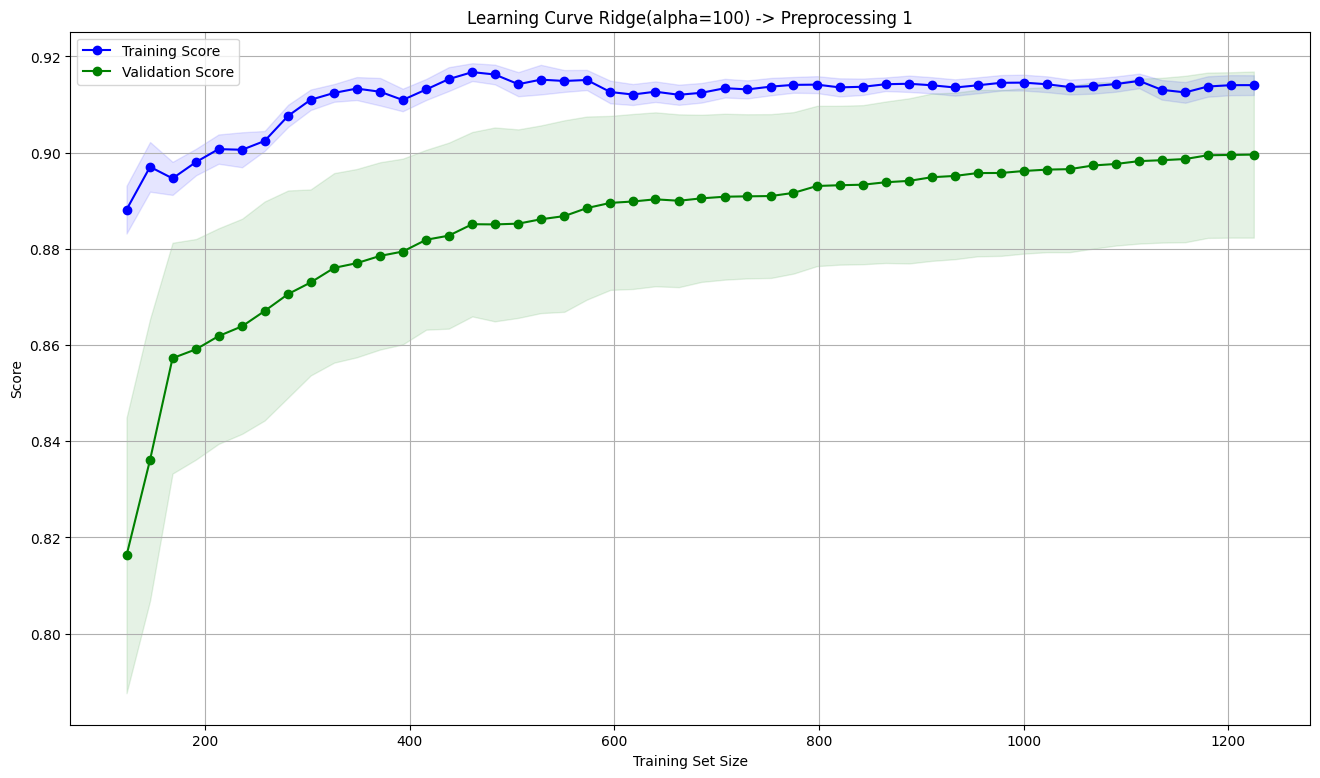

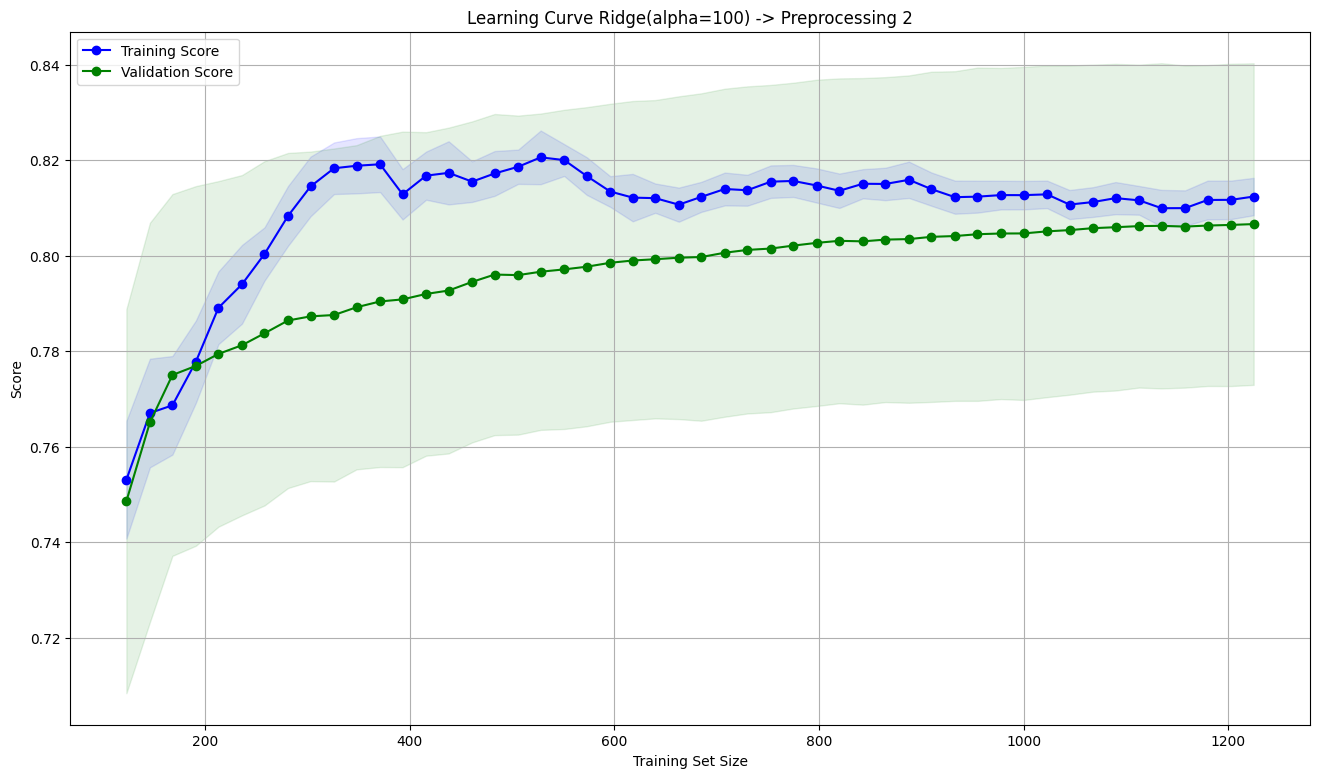

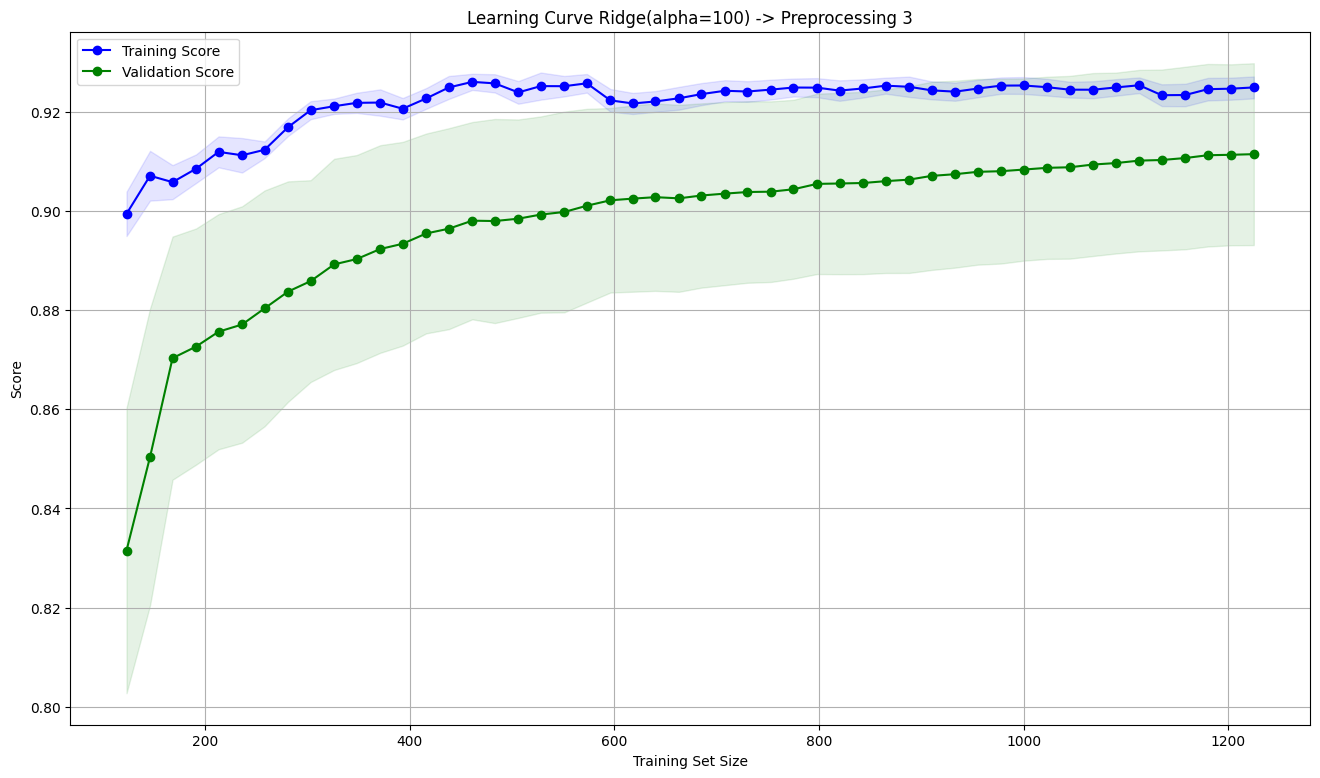

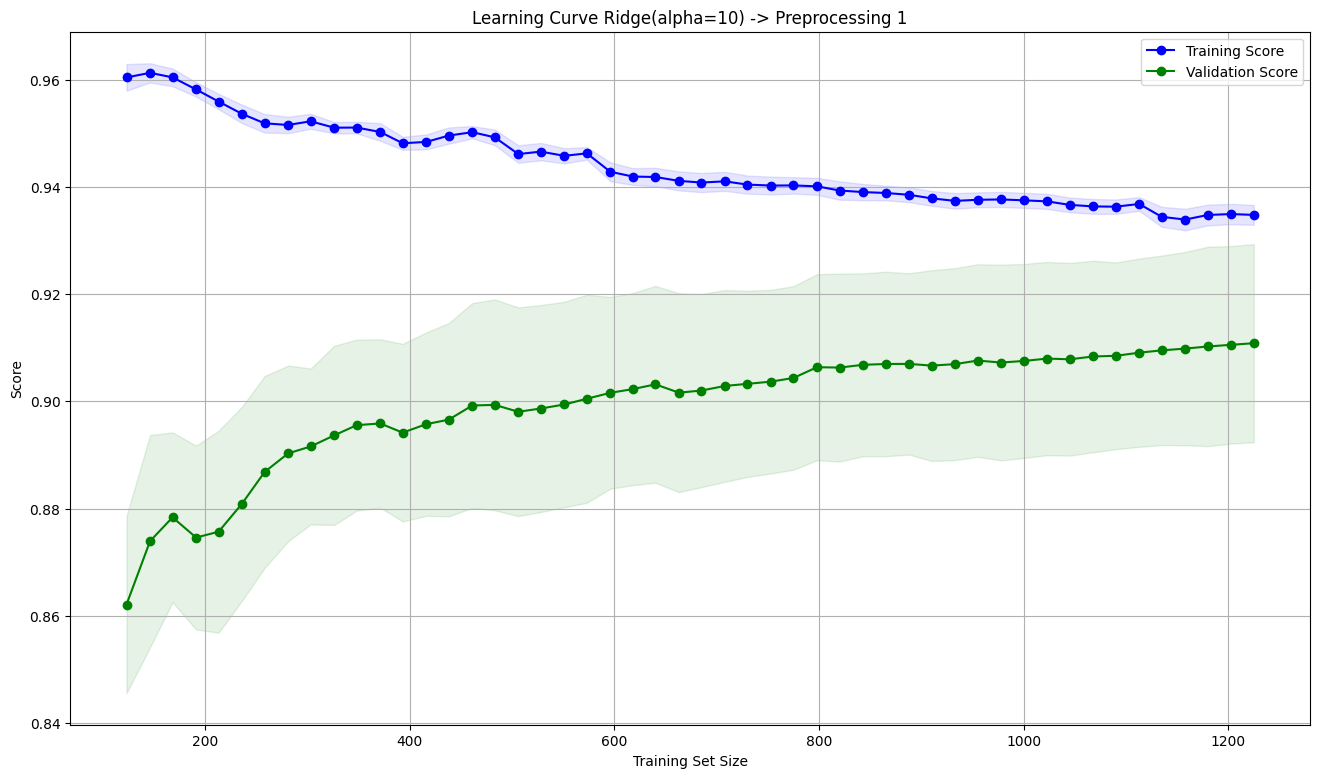

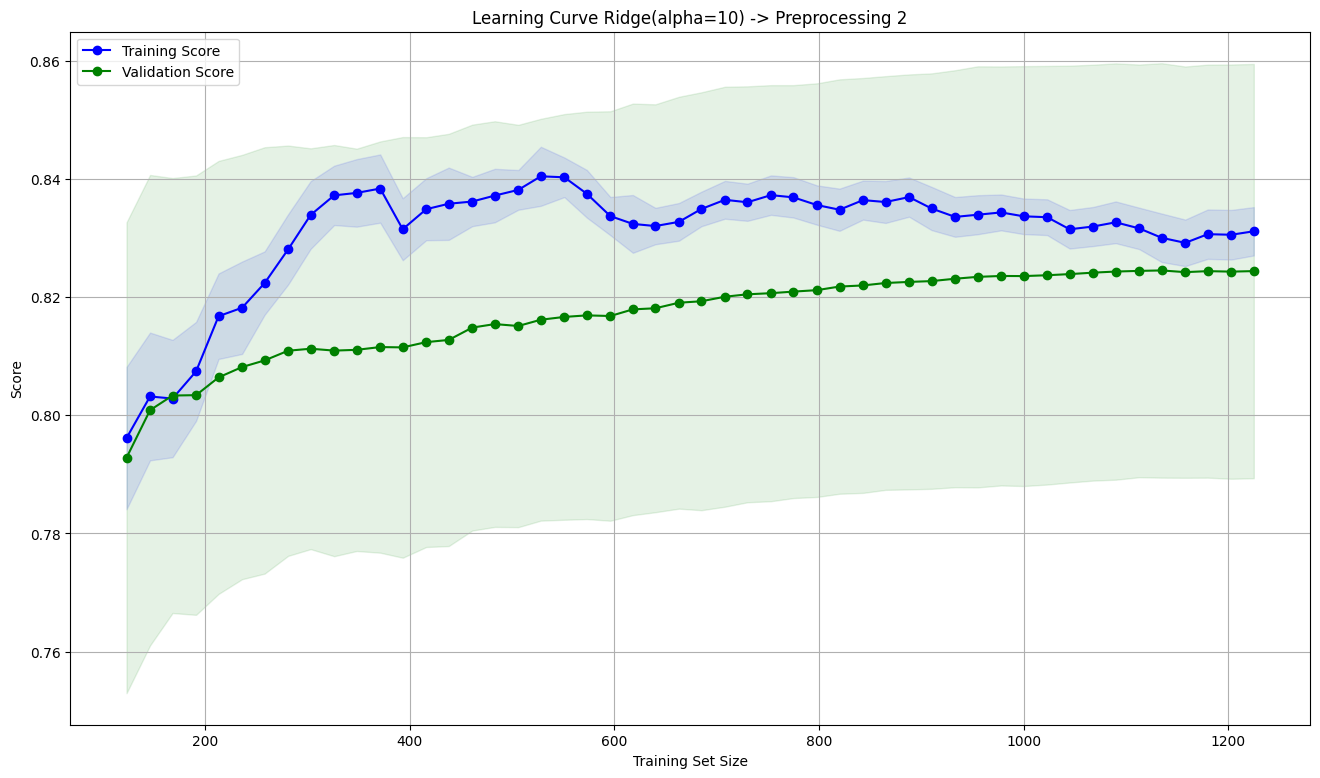

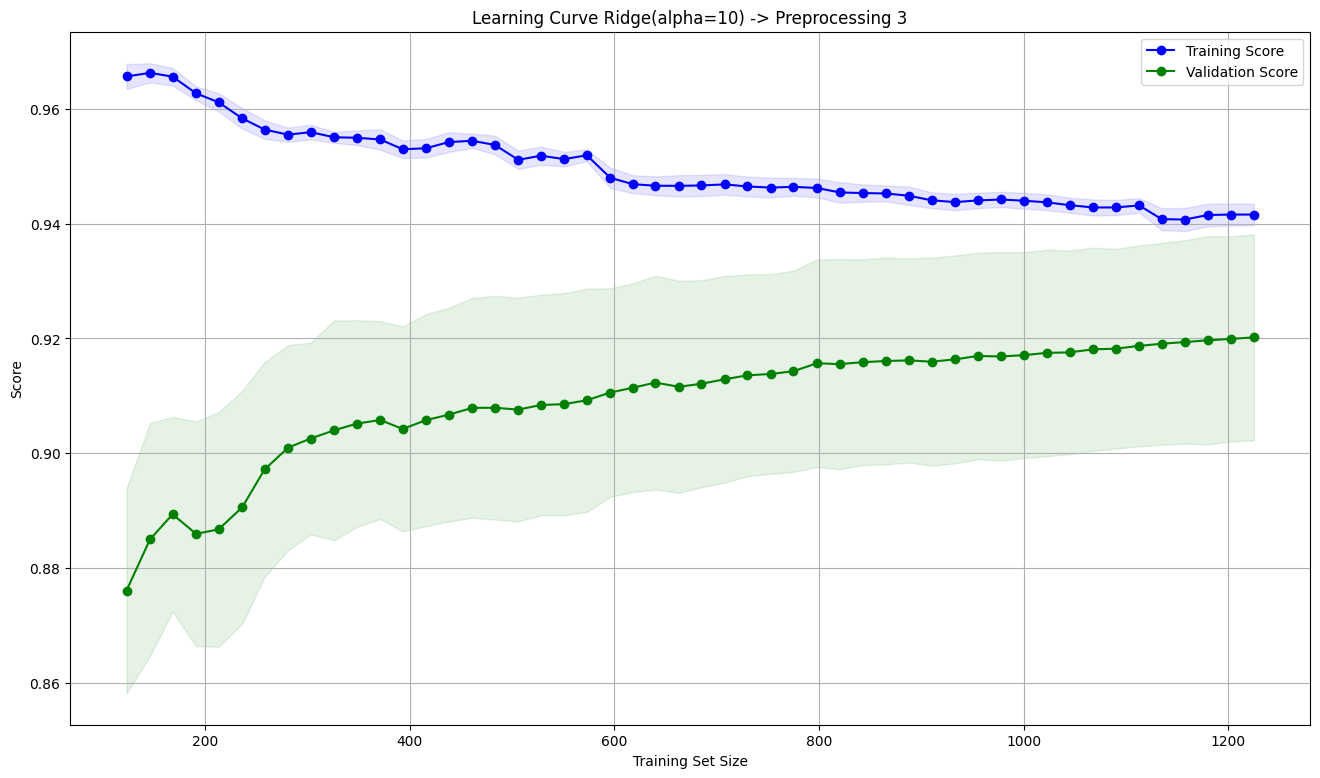

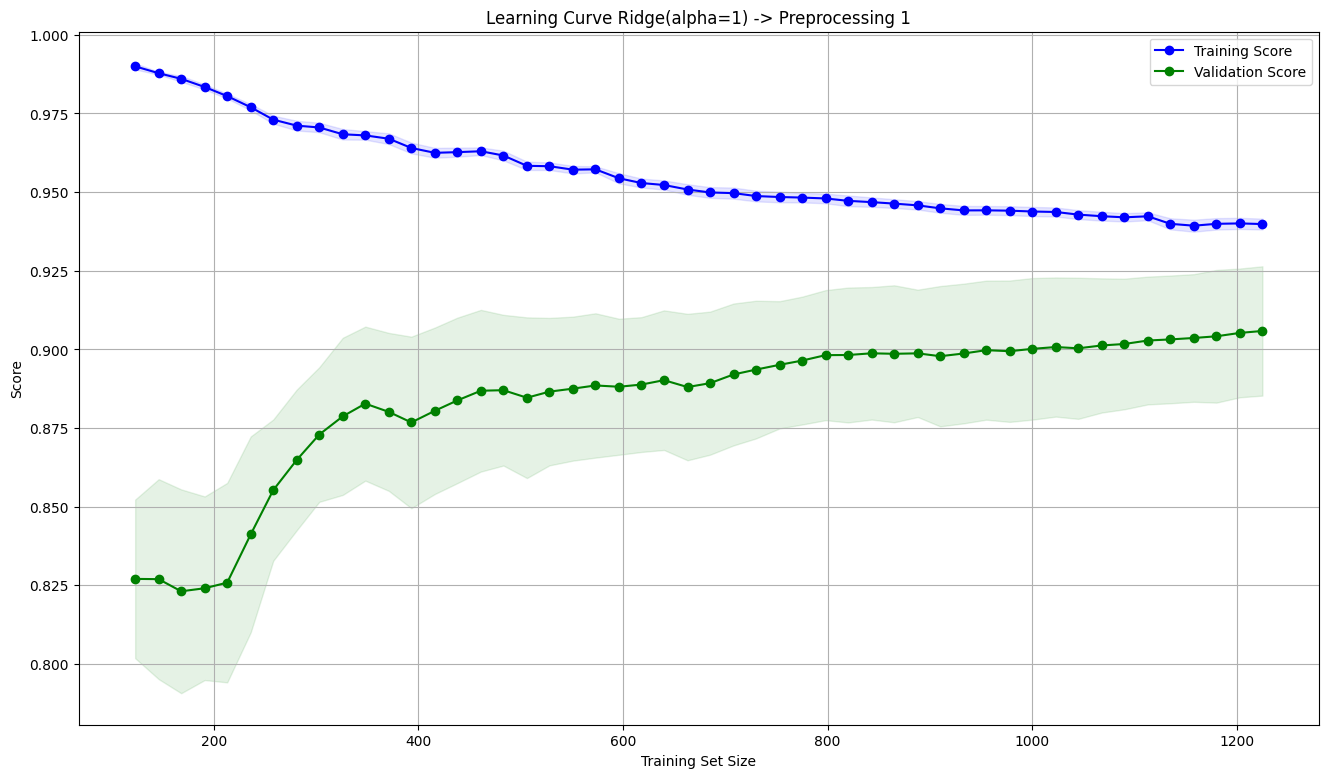

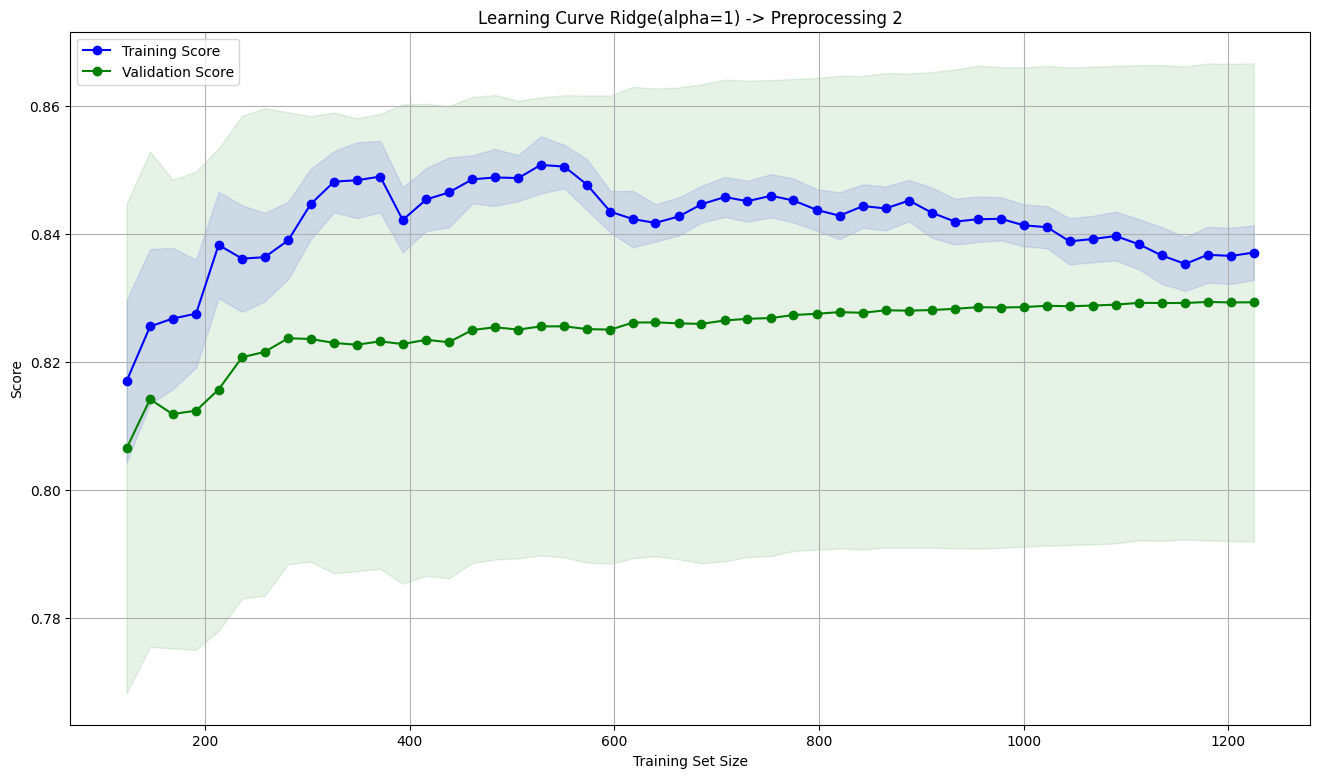

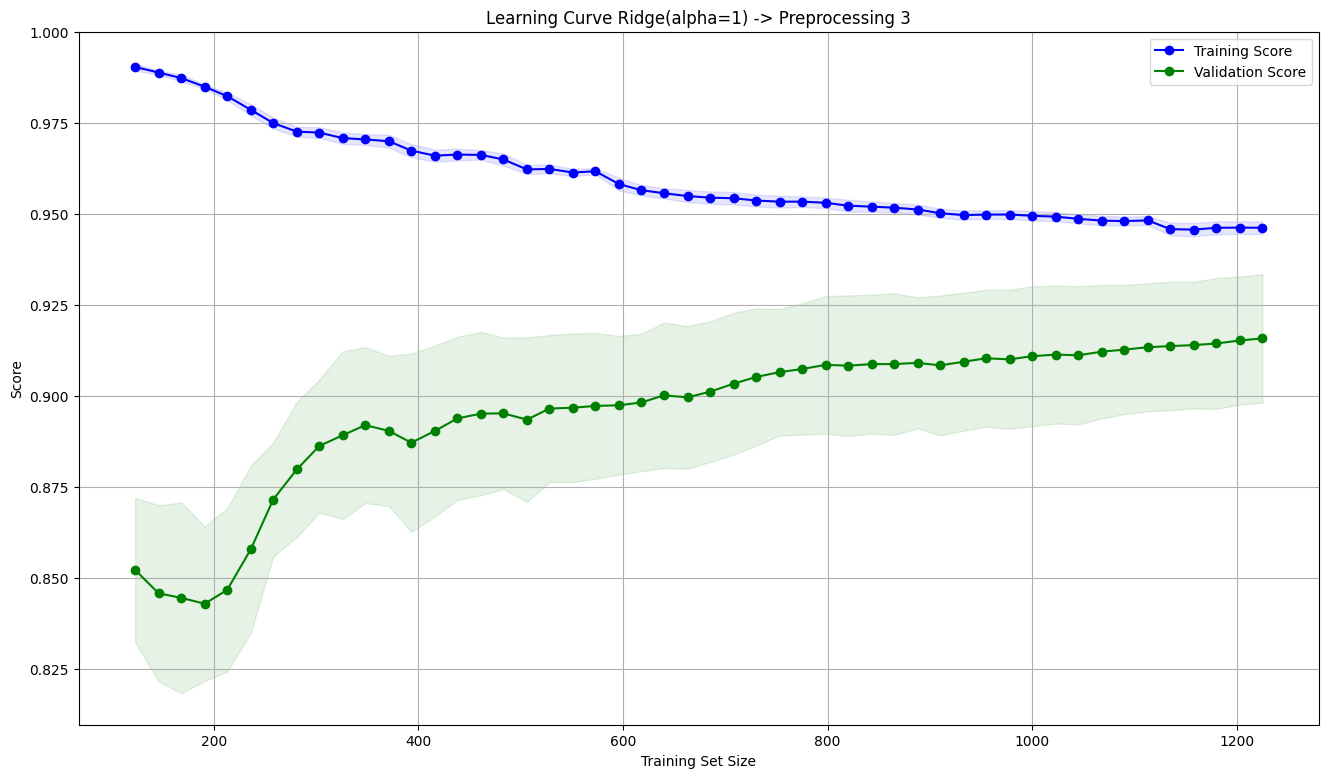

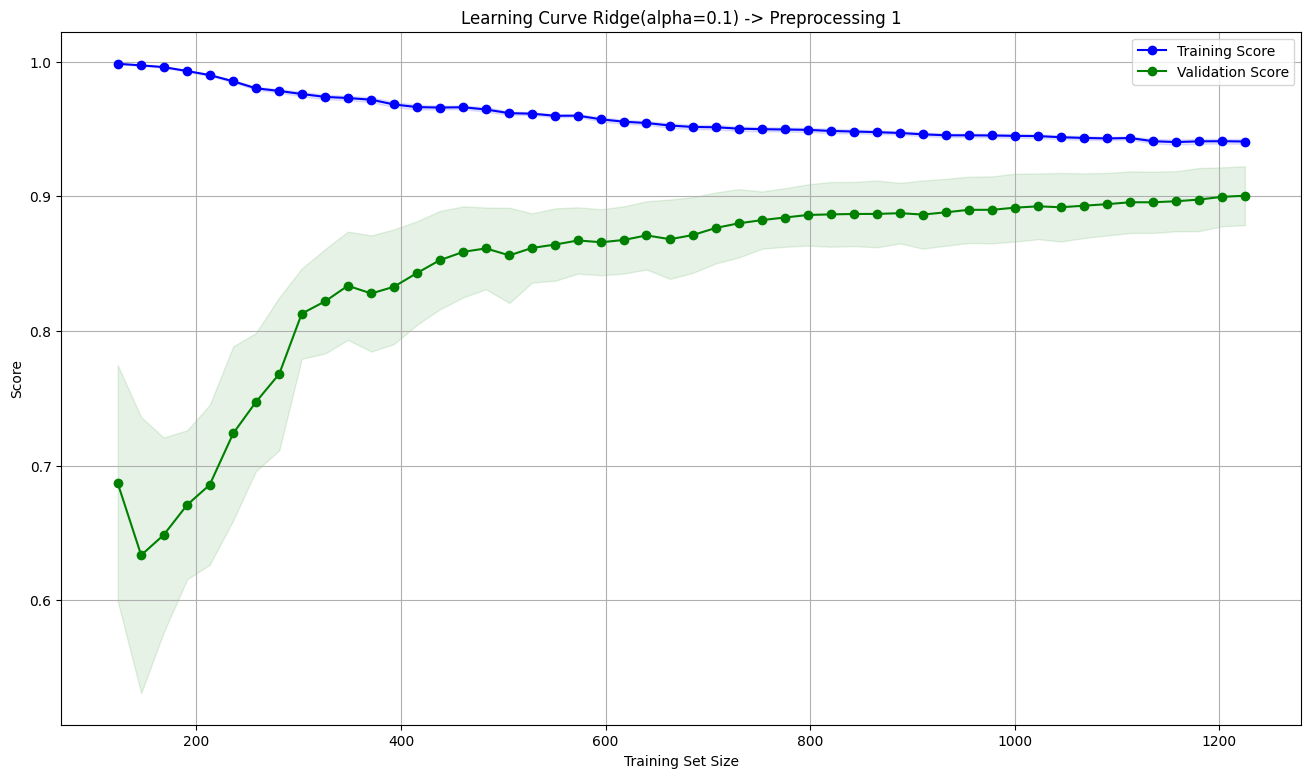

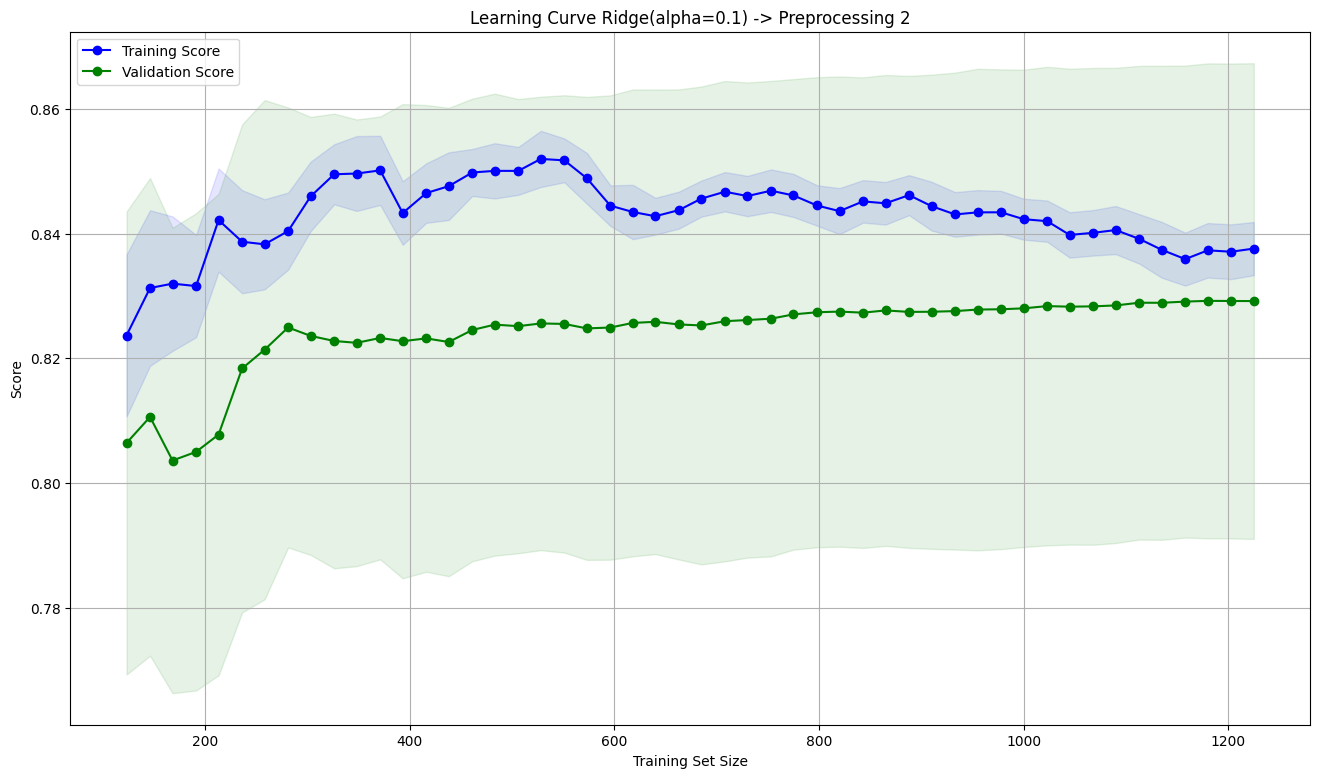

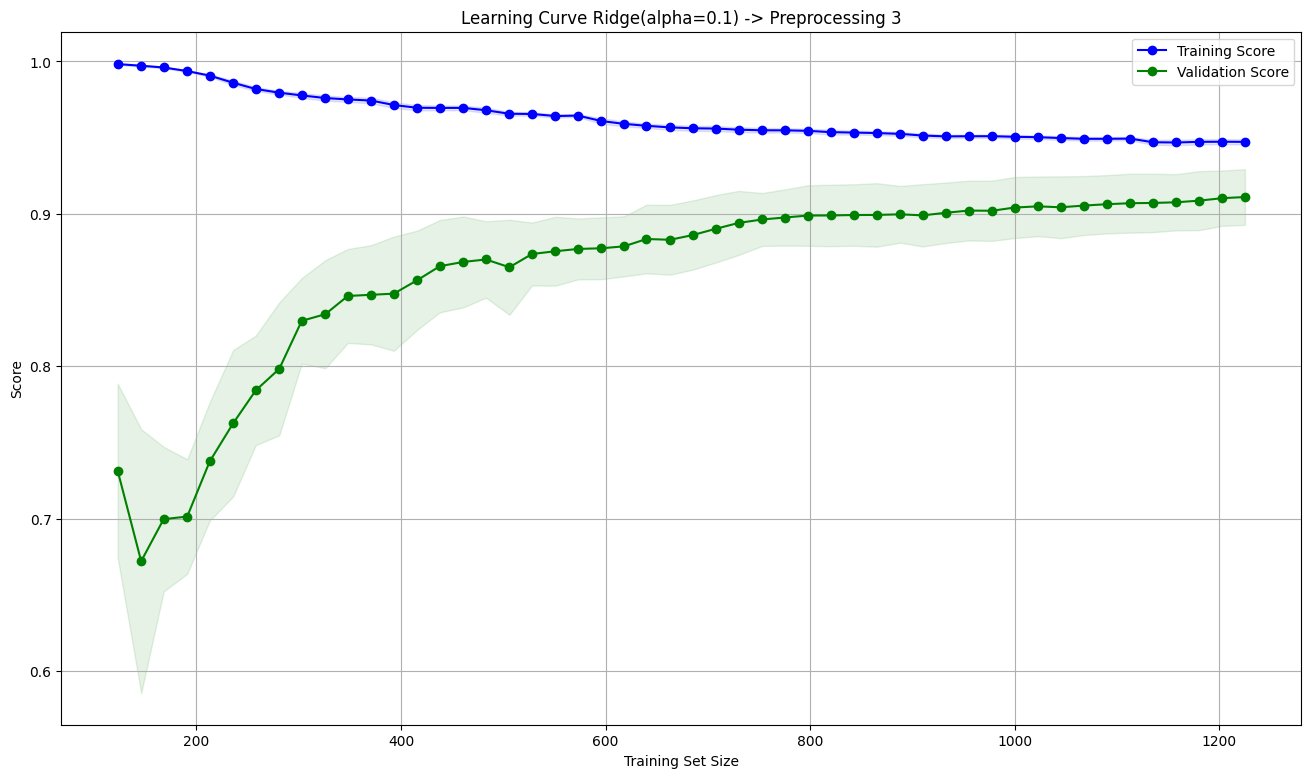

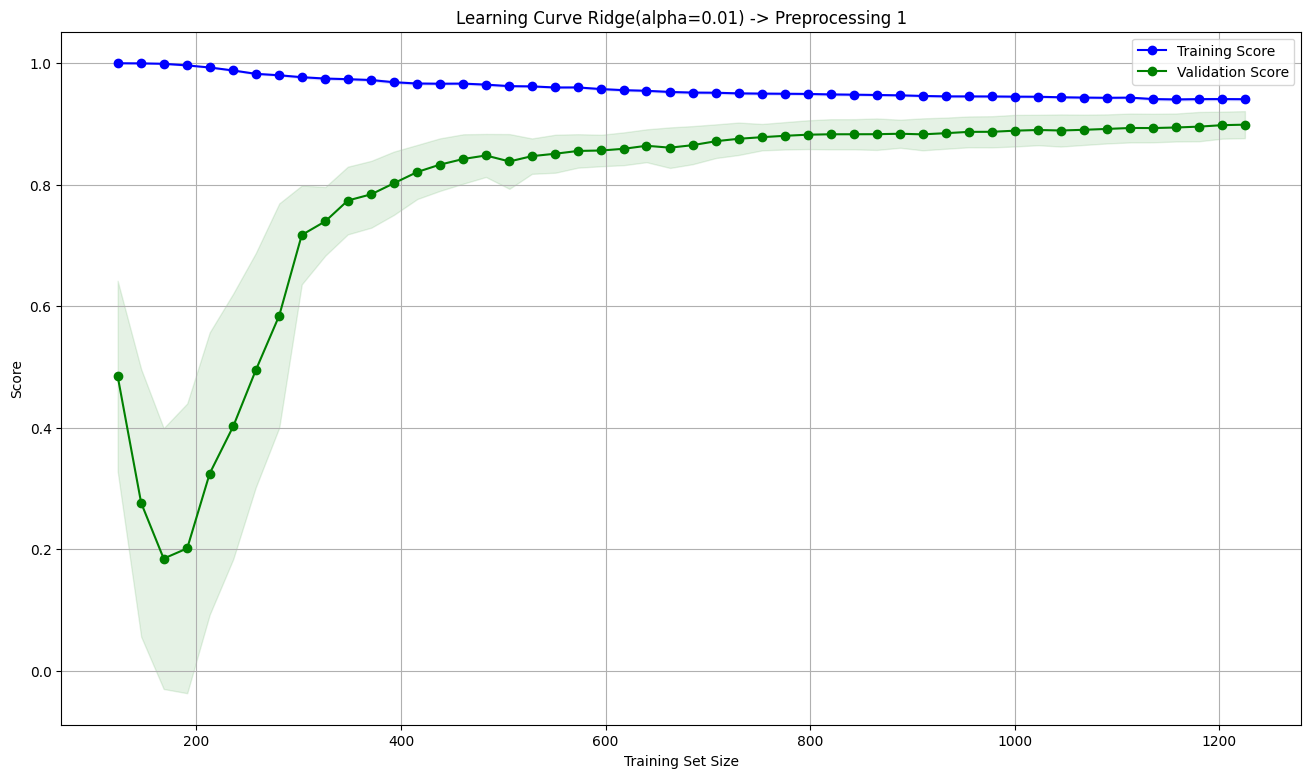

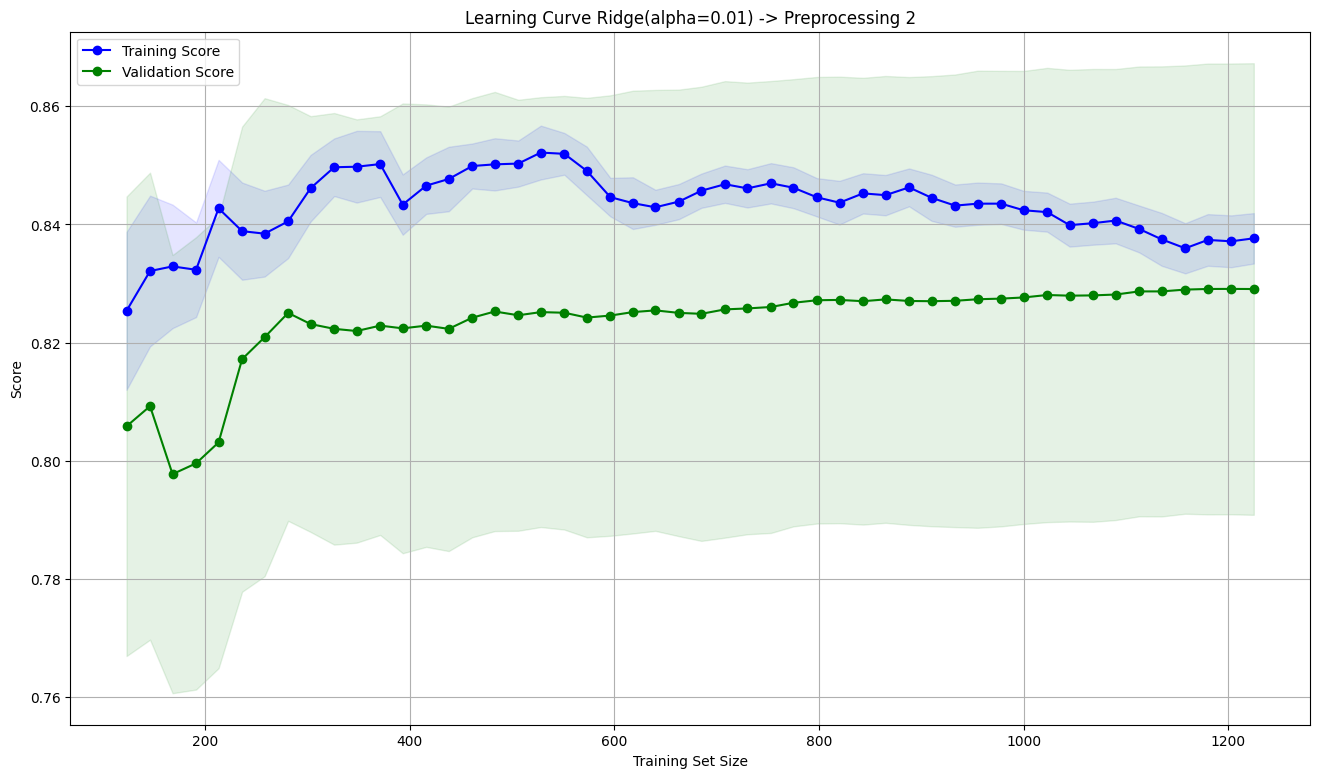

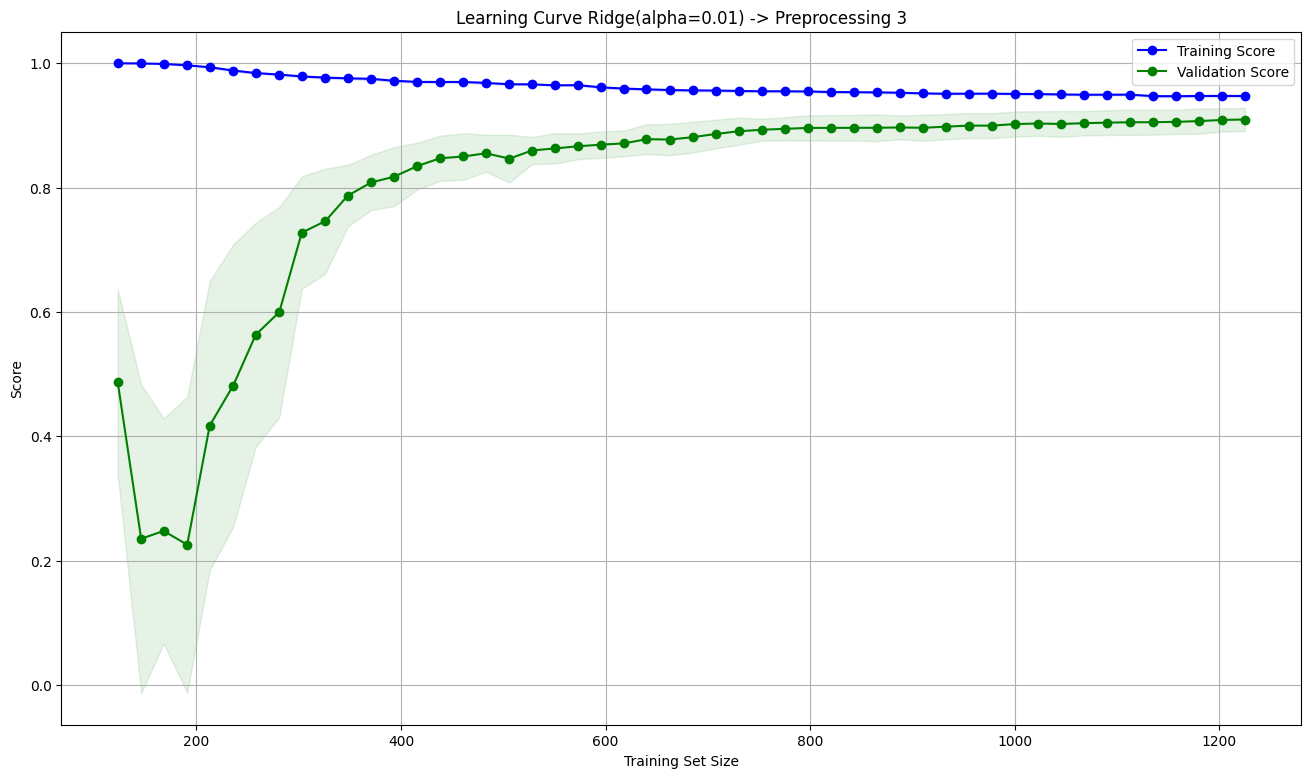

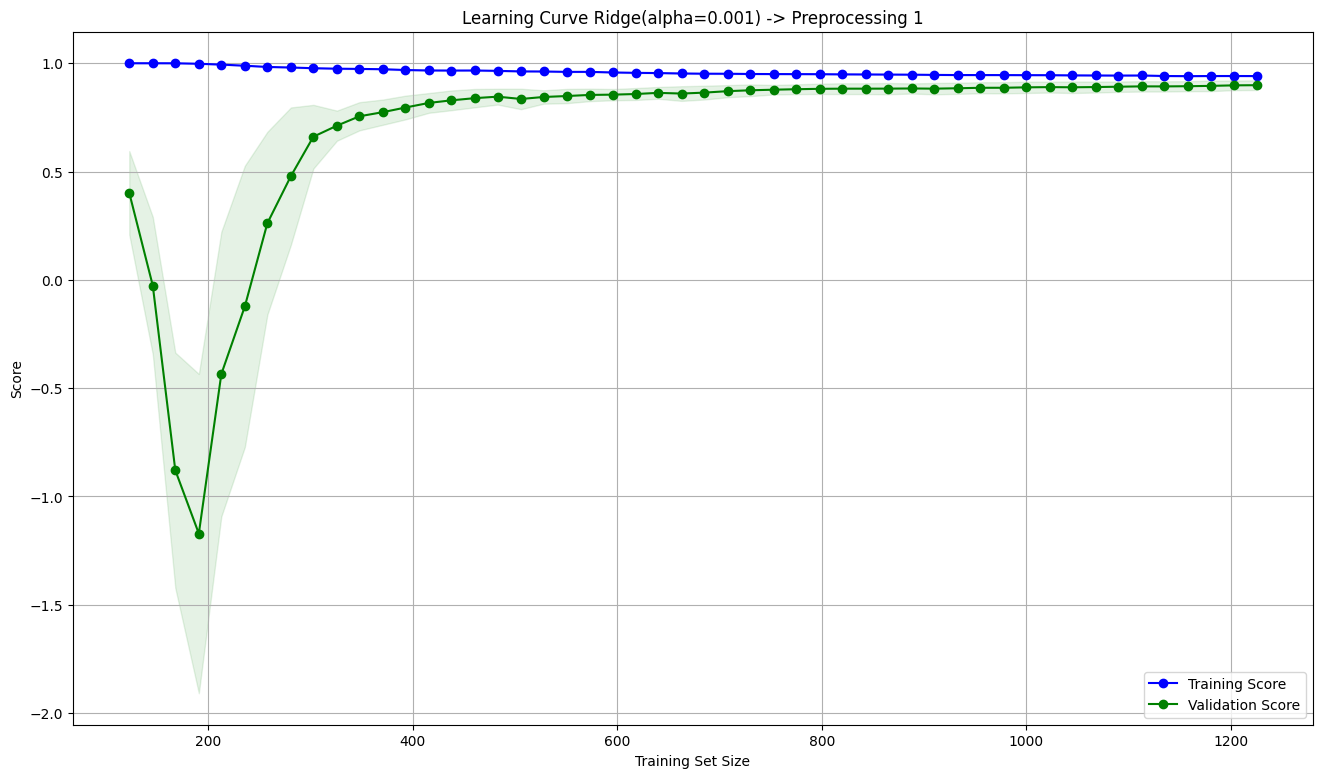

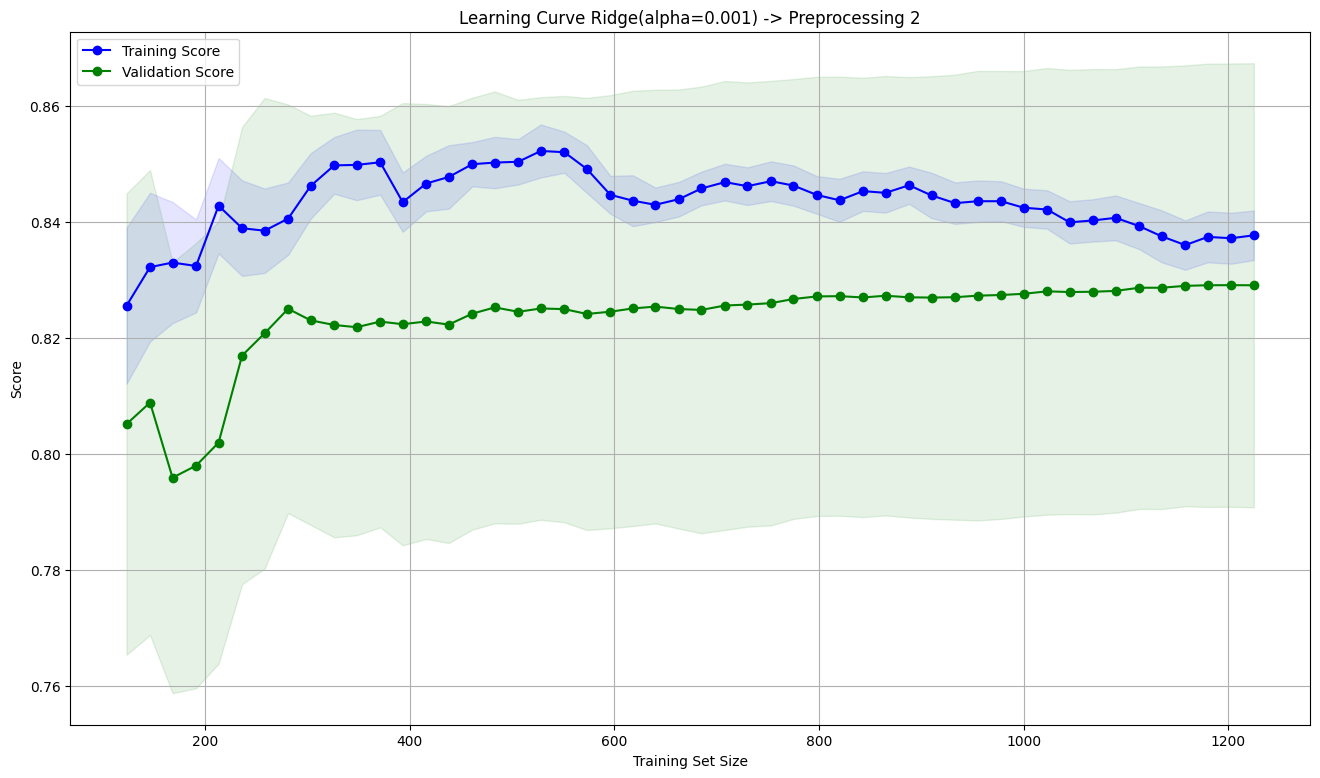

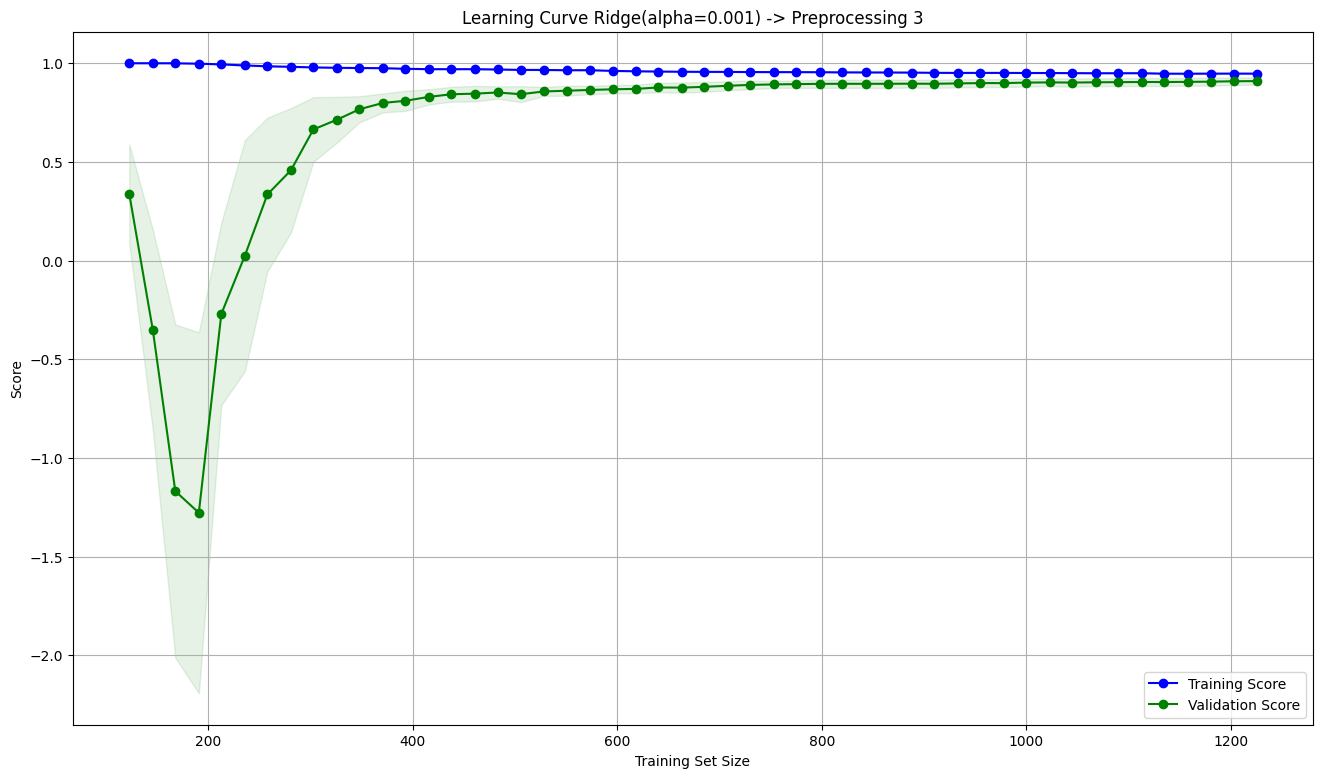

In [81]:
models = [Ridge(alpha=100), Ridge(alpha=10), Ridge(alpha=1), Ridge(alpha=0.1), Ridge(alpha=0.01), Ridge(alpha=0.001)]
preprocessing_types = {
    preprocessing1: "Preprocessing 1", 
    preprocessing2: "Preprocessing 2", 
    preprocessing3: "Preprocessing 3"
}

results_df = pd.DataFrame(index=None, columns=['Model', 'Final Training Score', 'Final Validation Score', 'Difference'])

for idx, model in enumerate(models):
    for preprocessing, preprocessing_name in preprocessing_types.items():
        predictions_pipeline = make_pipeline(preprocessing, model)
        train_sizes, train_scores, test_scores = learning_curve(
            predictions_pipeline, X_train, y_train, cv=KFold(n_splits=10, shuffle=True, random_state=42),
            n_jobs=-1, train_sizes=np.linspace(0.1, 0.99, 50)
        )
        results_df = plot_accuracy_curve(train_sizes, train_scores, test_scores, model, preprocessing_name, results_df)

In [82]:
results_df.dropna().sort_values("Difference")

Model  Final Training Score  \
1     Ridge(alpha=100) -> Preprocessing 2              0.812410   
4      Ridge(alpha=10) -> Preprocessing 2              0.831131   
7       Ridge(alpha=1) -> Preprocessing 2              0.837041   
10    Ridge(alpha=0.1) -> Preprocessing 2              0.837626   
13   Ridge(alpha=0.01) -> Preprocessing 2              0.837651   
16  Ridge(alpha=0.001) -> Preprocessing 2              0.837651   
2     Ridge(alpha=100) -> Preprocessing 3              0.924861   
0     Ridge(alpha=100) -> Preprocessing 1              0.914046   
5      Ridge(alpha=10) -> Preprocessing 3              0.941600   
3      Ridge(alpha=10) -> Preprocessing 1              0.934787   
8       Ridge(alpha=1) -> Preprocessing 3              0.946248   
6       Ridge(alpha=1) -> Preprocessing 1              0.939848   
11    Ridge(alpha=0.1) -> Preprocessing 3              0.947215   
14   Ridge(alpha=0.01) -> Preprocessing 3              0.947285   
17  Ridge(alpha=0.001) -> Preprocessing 3              0.947286   
9     Ridge(alpha=0.1) -> Preprocessing 1              0.940700   
12   Ridge(alpha=0.01) -> Preprocessing 1              0.940755   
15  Ridge(alpha=0.001) -> Preprocessing 1              0.940759   

    Final Validation Score  Difference  
1                 0.806643    0.005767  
4                 0.824393    0.006738  
7                 0.829274    0.007767  
10                0.829196    0.008429  
13                0.829063    0.008588  
16                0.829044    0.008607  
2                 0.911409    0.013452  
0                 0.899606    0.014439  
5                 0.920193    0.021407  
3                 0.910851    0.023935  
8                 0.915840    0.030408  
6                 0.905865    0.033983  
11                0.911014    0.036201  
14                0.909464    0.037820  
17                0.909321    0.037965  
9                 0.900418    0.040283  
12                0.898851    0.041904  
15                0.898562    0.042196

**Overfitted?**

The `Preprocessing 2` method has the lowest difference between *Final Training Score* and *Final Validation Score* but also significantly lower scores in general. In fact, in this comparison the model with `Preprocessing 3` might be the best one as it balances both final scores and their difference. However, taking into account the information comparing R2 and RMSE errors of all models, the `Ridge` with the first preprocessing method is more accurate (there is a diminutive *Difference* between those two). Also, we definitely go for the `alpha=10`. It is placed in the middle of the sorted table indicating good balance between the scores in general and the difference between them. Additionaly, those plots depict a much larger variance in the second preprocessing method, where only 6 out of 80 columns are used for training.

To conclude, the feared overfitting may be the case for the models at the bottom of this table but definitely not for the model selected, where the difference between 	*Final Training Score* and *Final Validation Score* is approximately **0.023935** (less than **2.4%**), while the high accuracy is still preserved (0.934787 - 0.910851 = 0.023935).

# Final Predictions

Final predictions for **test.csv**.

In [83]:
predictions_pipeline = make_pipeline(preprocessing1, Ridge(alpha=10, solver="auto"))
predictions_pipeline.fit(X_train, y_train)
predicted_SalePrice = predictions_pipeline.predict(new_data)

In [87]:
predicted_SalePrice = pd.Series(predicted_SalePrice, index=new_data.index, name="Saleprice")

filepath = Path(r"predicted_SalePrice.csv") 

predicted_SalePrice.to_csv(filepath)
predicted_SalePrice

Id
1461    118111.891632
1462    168297.066709
1463    188348.749266
1464    202984.361267
1465    200376.540851
            ...      
2915     85155.602591
2916     73407.814058
2917    182609.985789
2918    119662.066941
2919    227219.926472
Name: Saleprice, Length: 1459, dtype: float64